In [18]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl
import pandas as pd

# import jupyternotify
import pylab as pl
import subprocess
import concurrent.futures
import shutil

# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)


In [19]:

os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')


ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --keep-disks | --zone

For detailed information on this command and its flags, run:
  gcloud compute instances delete --help
ERROR: (gcloud.compute.instances.delete) argument INSTANCE_NAMES [INSTANCE_NAMES ...]: Must be specified.
Usage: gcloud compute instances delete INSTANCE_NAMES [INSTANCE_NAMES ...] [optional flags]
  optional flags may be  --delete-disks | --help | --k

512

In [21]:
config_list = [  'cre_setup_1n_scale_3_node_info', 'cre_setup_1n_scale_4_node_info']



# config_list = ['cre_setup_2_scale_1_node_info']

# config_list2 = ['global_12cls',\
#                 'local_12cls',\
#                'global_3cls',\
#                'global_4cls',\
#                'global_6cls',\
#                'global_8cls',\
#                'global_2cls',\
#                'local_3cls',\
#                'local_4cls',\
#                'local_6cls',\
#                'local_8cls',\
#                'local_2cls']
# config_list2 = ['local_2cls']


config_list = config_list

In [22]:
config_list

['cre_setup_1n_scale_3_node_info', 'cre_setup_1n_scale_4_node_info']

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 1
22 1
23 1
24 1
25 1
26 1
27 -1
28 -1
29 -1
30 -1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 -1
47 -1
0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'europe-west3-c'
12 12  'europe-west3-c'
13 13  'europe-west3-c'
14 14  'europe-west3-c'
15 15  'europe-west3-c'
16 16  'europe-west3-c'
17 17  'europe-west3-c'
18 18  'europe-west3-c'
19 19  'europe-west3-c'
20 20  'europe-west3-c'
21 21  'europe-west3-c'
22 22  'europe-west3-c'
23 23  'europe-west3-c'
24 24  'europe-west3-c'
25 25  'europe-west3-c'
26 26  'europe-west3-c'
27 27  'europe-west3-c'
28 28  'europe-west3-c'
29 29  'europe-west3-c'
30 30  'europe-west3-c'
31 31 

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-21].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-21  europe-west3-c  e2-highmem-2               10.156.0.12  34.159.152.46  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-13].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-13  europe-west3-c  e2-highmem-2               10.156.0.16  34.159.151.233  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-26].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-26  europe-west3-c  e2-highmem-2               10.156.0.17  34.159.78.64  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-19].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-43].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-19  europe-west3-c  e2-highmem-2               10.156.0.43  35.198.183.177  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-43  asia-south1-c  e2-highmem-2               10.160.0.7   34.100.156.16  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-33].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-41].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-18].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-33  asia-south1-c  e2-highmem-2               10.160.0.11  34.100.218.8  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-41  asia-south1-c  e2-highmem-2               10.160.0.29  34.100.230.24  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-46].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-30].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-32].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-20].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-34].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'project

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-18  europe-west3-c  e2-highmem-2               10.156.0.74  35.246.133.159  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-46  asia-south1-c  e2-highmem-2               10.160.0.33  35.244.7.169  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-30  europe-west3-c  e2-highmem-2               10.156.0.52  35.246.216.16  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.28  34.89.128.60  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-27].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-20  europe-west3-c  e2-highmem-2               10.156.0.55  35.246.168.32  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-32  asia-south1-c  e2-highmem-2               10.160.0.41  34.93.23.26  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-12  europe-west3-c  e2-highmem-2               10.156.0.48  34.107.56.43  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.0.110  35.242.237.112  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-27  europe-west3-c  e2-highmem-2               10.156.0.97  34.159.240.150  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-15].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.0.116  35.198.180.141  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.78  35.234.90.249  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-15  europe-west3-c  e2-highmem-2               10.156.0.113  34.107.80.106  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-40].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-34  asia-south1-c  e2-highmem-2               10.160.0.48  34.93.63.127  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-16].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-40  asia-south1-c  e2-highmem-2               10.160.0.50  35.200.217.221  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.0.123  34.159.42.30  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-11].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-23].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-42].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-25].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-17].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubu

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-16  europe-west3-c  e2-highmem-2               10.156.15.192  34.89.131.187  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-23  europe-west3-c  e2-highmem-2               10.156.0.114  35.246.169.233  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-25  europe-west3-c  e2-highmem-2               10.156.0.80  34.107.120.254  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.85  34.159.171.97  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-42  asia-south1-c  e2-highmem-2               10.160.0.44  34.93.193.100  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-22].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-17  europe-west3-c  e2-highmem-2               10.156.0.112  34.107.12.238  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-11  europe-west3-c  e2-highmem-2               10.156.0.122  35.198.170.57  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-28  europe-west3-c  e2-highmem-2               10.156.0.111  35.242.240.85  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-31].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-14].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggest

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-22  europe-west3-c  e2-highmem-2               10.156.15.194  34.89.239.62  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.88  35.246.255.173  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.83  34.107.13.191  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.117  35.234.78.225  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-14  europe-west3-c  e2-highmem-2               10.156.0.119  35.246.199.179  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-04  europ

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-37].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-45].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-24].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/

NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-36  asia-south1-c  e2-highmem-2               10.160.0.112  34.93.115.245  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-37  asia-south1-c  e2-highmem-2               10.160.0.52  34.93.13.83  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-45  asia-south1-c  e2-highmem-2               10.160.0.106  34.93.31.250  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-24  europe-west3-c  e2-highmem-2               10.156.15.193  35.198.153.198  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-47  asia-south1-c  e2-highmem-2               10.160.0.53  34.100.174.237  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-38].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-39].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-35].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-29].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.15.195  35.246.142.12  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-29  europe-west3-c  e2-highmem-2               10.156.15.196  34.159.189.205  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-38  asia-south1-c  e2-highmem-2               10.160.0.110  34.93.168.141  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-44].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-39  asia-south1-c  e2-highmem-2               10.160.0.107  34.100.153.55  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-35  asia-south1-c  e2-highmem-2               10.160.0.108  35.244.11.39  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-44  asia-south1-c  e2-highmem-2               10.160.0.109  34.93.140.209  RUNNING
test:  7001 10.156.0.97
test:  7002 10.156.0.111
test:  7003 10.156.15.196
test:  7004 10.156.0.52
test:  7005 10.160.0.33
test:  7006 10.160.0.53


[sudo] password for tejas: 


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/tejas/work/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 3s
3 actionable tasks: 3 executed


[sudo] password for tejas: 

> Task :clean

BUILD SUCCESSFUL in 1s
1 actionable task: 1 executed

----------


----------


----------


----------

test:  0 10.156.0.116 10000 20000 0

test:  1 10.156.0.78 10000 20000 0

test:  2 10.156.0.85 10000 20000 0

test:  3 10.156.0.28 10000 20000 0

test:  4 10.156.0.125 10000 20000 0

test:  5 10.156.0.123 10000 20000 0

test:  6 10.156.0.83 10000 20000 0

test:  7 10.156.15.195 10000 20000 0

test:  8 10.156.0.88 10000 20000 0

test:  9 10.156.0.117 10000 20000 0

test:  10 10.156.0.110 10000 20000 0

test:  11 10.156.0.122 10000 20000 0

test:  12 10.156.0.48 10000 20000 0

test:  13 10.156.0.16 10000 20000 0

test:  14 10.156.0.119 10000 20000 0

test:  15 10.156.0.113 10000 20000 0

test:  16 10.156.15.192 10000 20000 0

test:  17 10.156.0.112 10000 20000 0

test:  18 10.156.0.74 10000 20000 0

test:  19 10.156.0.43 10000 20000 0

test:  20 10.156.0.55 10000 20000 0

test:  21 10.156.0.12 10000 20000 1

test:  22 10.156.15.194 10000 20000 1

test:  23 10.156.0.114 1

To github.com:tmane002/BftSmart_Final.git
   87042f74..7d3c042f  HEAD -> main


ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-116.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-78.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-85.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-28.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-125.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-123.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-83.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-15-195.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-88.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-117.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-110.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-122.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-10-156-0-48.us-west-1.

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 P

Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 P

Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3109 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [415 kB]
Get:14 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:15 http://security.ubuntu.com/ubuntu focal-security/restr

Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [374 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages

Get:42 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1165 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/

Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Get:31 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://euro

Get:15 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [279 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [26.1 kB]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse Translation-en [7768 B]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 c-n-f Metadata [620 B]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:3 http://europe-west3.gce.archive.ubuntu

Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [938 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [498 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/

Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:15 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [374 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [415 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2569 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1165 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe Translation-en [279 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/universe amd64 c-n-f Metadata [25.7 kB]
Get:21 http://europe-west3.gce.arc

Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [358 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [938 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:38 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [197 kB]
Get:39 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [19.2 kB]
Get:40 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [23.9 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/m

Get:25 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:26 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2569 kB]
Fetched 30.2 MB in 4s (8009 kB/s)
Reading package lists...Get:27 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [358 kB]
Get:28 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:29 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [938 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:30 http://security.ubuntu.com/ubuntu focal-security


Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b

The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
Suggested packages:
 

Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [45.7 kB]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 c-n-f Metadata [880 B]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports/multiverse amd64 c-n-f Metadata [116 B]

Reading

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 30.2 MB in 4s (7869 kB/s)
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Fetched 48.2 MB in 1s (42.0 MB/s)
Selecting previously unselected package libbinutils:amd64.
Reading package lists...Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...

Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
(Reading database ... 95%
Reading state information...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable t

Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.c

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
(Reading database ... 80%
Reading package lists...%
Building dependency tree...Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emac


Reading state information...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libquadmath0:amd64.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-j

Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-172.1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libdpkg-perl.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.

Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Fetched 30.2 MB in 6s (5346 kB/s)
Reading package lists...Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Selecting previously unselected 

Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...

Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Fetched 30.2 MB in 6s (5384 kB/s)
Reading package lists...Reading package lists...
Building dependency tree...

Reading state information...


Fetched 30.2 MB in 6s (5264 kB/s)
Reading package lists...Fetched 30.2 MB in 6s (5367 kB/s)
Reading package lists...Reading package lists...
Building dependency tree...Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Fetched 30.2 MB in 6s (5303 kB/s)
Reading package lists...Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 30.2 MB in 6s (5383 kB/s)
Reading package lists...
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates

Selecting previously unselected package libubsan1:amd64.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Reading package lists...  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 li

Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.

Reading state information...
Reading package lists...Reading package lists...

Reading package lists...Building dependency tree...The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsen

Reading package lists...Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
  libxpm4 libxrandr2 libxrender1 libxshmfence1 libxt6 libxtst6 libxv1
  libxxf86dga1 libxxf86vm1 mesa-vulkan-drivers openjdk-11-jre
  openjdk-11-jre-headless x11-common x11-utils
Suggested packages:
  cups-common liblcms2-utils pcscd lm-sensors libnss-mdns fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
  mesa-utils
Unpacking libfile-fcntllock-perl (0.22-3build4) ...

Reading state information...The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 li

  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers openjdk-11-jre openjdk-11-jre-headless x11-common
  x11-utils
0 upg

  gdb gcc-doc gcc-9-multilib glibc-doc bzr libstdc++-9-doc make-doc
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Reading package lists...Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-172.190 [1131 kB]
Fetched 30.2 MB in 6s (5202 kB/s)
Reading package lists...Setting up libfakeroot:amd64 (1.24-1) ...

The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm

Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-dev-bin amd64 2.31-0ubuntu9.14 [71.8 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 linux-libc-dev amd64 5.4.0-172.190 [1


Reading package lists...Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0

Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java de

Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockd

Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 l



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:23 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [20

Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]

Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]

Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 lib



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]

The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Selecting previously unselected package libalgorithm-diff-perl.
Reading package lists...  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpage

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils

Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Setting up libisl22:amd64 (0.22.1-1) ...
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB

Setting up gcc (4:9.3.0-1ubuntu2) ...
The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0

Building dependency tree...Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Fetched 30.2 MB in 6s (5107 kB/s)
Reading package lists...  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcm

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libbinutils:amd64.
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/mai

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Selecting previously unselected package binutils-x86-64-linux-gnu.
(Reading database ... 62221 files and directories currently installed.)Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...

Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...

Reading state information...
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
Get:15 http://europe-wes

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils-common:amd64.
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin

Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:22 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Selecting previously unselected package binutils.
Get:36 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfakeroot amd64 1.24-1 [25.7 kB]
Get:37 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fakeroot amd64 1.24-1 [62.6 kB]
Get:38 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-perl all 1.19.03-2 [46.6 kB]
Get:39 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6 [11.3 kB]
Get:40 http://eu

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libctf-nobfd0:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...

Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Fetched 48.2 MB in 2s (21.6 MB/s)
Selecting previously unselected package binutils-common:amd64.
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten


Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
(Reading database ... 62221 files and directories currently installed.)
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Pr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Selecting previously unselected package libctf-nobfd0:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libmpc3:amd64 (1.1.0-1) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package binutils-common:amd64.
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Selecting previously unselected package binutils.
Get:34 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Get:35 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 build-essential amd64 12.8ubuntu1.1 [4664 B]
Unpacking binutils 

(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...Selecting previously unselected package binutils-x86-64-linux-gnu.

Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc-9-base:amd64.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
(Reading database ... 62221 files and directories currently installed.)
Pre

Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-172.190_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-172.190) ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package cpp-9.
Selecting previously unselected package libctf0:amd64.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Selecting previously unselected package binutils.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpackin

Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package binutils-x86-64-linux-gnu.
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libisl22:amd64 (0.22.1-1) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 li

Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack ..

Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libctf0:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb

Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package gcc-9.
Selecting previously unselected package cpp-9.
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../18-libatomic1_10.5.0-1ubuntu1~2

Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libasan5:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Get:24 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Get:25 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libtsan0:amd64.
Get:26 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting pr

Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package cpp-9.
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package gcc.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...

Unpacking libcc1-0

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:27 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Selecting previously unselected package libgomp1:amd64.
Fetched 48.2 MB in 1s (54.9 MB/s)
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package libasan5:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd

Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...

Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Prepa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking lib

Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libquadmath0:amd64.
Unpacking libc6:amd64 (2.31-0ubuntu9.14) over (2.31-0ubuntu9.9) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package cpp.
Selecting previously unselected package libquadmath0:amd64.

Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Pr

Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package gcc-9.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Reading package lists...Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package gcc-9.

Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Building dependency tree...Selecting previously unselected package g++-9.
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_a

Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...Selecting previously unselected package manpages-dev.

Setting up libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected package libctf0:amd64.
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking fakeroot (1.24-1) ...
Unpacking make (4.2.1-1.2) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Fetched 396 kB in 0s (1773 kB/s)
Selecting previously unselected package gcc-9.
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unsele

Unpacking linux-libc-dev:amd64 (5.4.0-172.190) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...Setting up libfakeroot:amd64 (1.24-1) ...

Unpacking fakeroot (1.24-1) ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package g++-9.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up fakeroot (1.24-1) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...Selecting previously unselected package g++-9.
Selecting previously unselected package gcc.
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Reading package lists...update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode

Selecting previously 

Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Selecting previously unselected package libalgorithm-diff-perl.
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Setting up libfakeroot:amd64 (1.24-1) ...
Preparing to unpack .../36-libalgorithm-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Unpacking g++ (4:9.3.0-1ubuntu2) ...Selecting previously unselected package gcc.
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...

Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking gcc (4:9.3.0-1ubuntu2) ...
Setting up make (4.2.1-1.2) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package make.update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto 

Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up fakeroot (1.24-1) ...
Selecting previously unselected package make.
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up make (4.2.1-1.2) ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package gcc.
Unpacking make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Preparing to unpack .../26-gcc_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) i

update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package fakeroot.
Selecting previously unselected package libalgorithm-merge-perl.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../35-fakeroot_1.24-1_amd64.deb ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to 

Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Selecting previously unselected package libtsan0:amd64.
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package manpages-dev.
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting previously unselected package build-essential.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
S

Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package manpages-dev.
Selecting previously unselected package libitm1:amd64.
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up linux-libc-dev:amd64 (5.4.0-172.190) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Selecting previously unselected package make.
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up linux-libc-dev:amd64 (5.4.0-172.190) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking manpages-dev (5.05-1) ...
Prep

job.sh: 12: sdk: not found


Building dependency tree...Setting up fakeroot (1.24-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up manpages-dev (5.05-1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up manpages-dev (5

Setting up fakeroot (1.24-1) ...Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package liblsan0:amd64.
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-c

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libdpkg-perl.
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package libfile-fcntllock-perl.

Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libalgorithm-merge-perl (0.08-3) ...Selecting previously unselected package libalgorithm-diff-perl.
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Setting up liblsan0:amd64 (10.5.0-1ub

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Setting up manpages-dev (5.05-1) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Reading package lists...Setting up libfile-fcntllock-perl (0.22-3build4) ...

Setting up libalgorithm-diff-perl (1.19.03-2) ...
Building dependency tree...
Reading state information...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack ...

job.sh: 12: sdk: not found


Selecting previously unselected package libgcc-9-dev:amd64.
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previously unselected package manpages-dev.
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up manpages-dev (5.05-1) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libubsan1:amd64 (10.5.

Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up binutils (2.34-6ubuntu1.8) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp (4:9.3.0-1ubuntu2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up manpages-dev (5.05-1) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.8ubuntu1.1) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Processing triggers for ma

job.sh: 12: sdk: not found


Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core jav

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libalgorithm-merge-perl.
Fetched 43.0 MB in 1s (46.6 MB/s)
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Unpacking ca-certificates-java (20190405ubuntu1.1) ...Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...

Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Unpacking manpages-dev (5.05-1) ...
Selecting previously unselected p

job.sh: 12: sdk: not found


Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Reading package lists...Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...

Building dependency tree...Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libctf0:amd64 (2.34-6ubuntu1.8) ...
Setting up libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libcups2:amd64.
Preparing to

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 43.0 MB in 10s (4302 kB/s)
Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client

Updating certificates in /etc/ssl/certs...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm

Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
done.
done.
Setting up libavahi-client3:amd64 (0.7-

Adding debian:TeliaSonera_Root_CA_v1.pem
The following packages will be upgraded:
  iputils-ping
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
done.
Setting up ant-optional (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (1050 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up iputils-ping (3:20190709-3ubuntu1) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pemProcessing triggers for man-db (2.9.1-1) ...

Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Ro

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be u

'unknown': I need something more specific.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (872 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Reading package lists...Setting up iputils-ping (3:20190709-3ubuntu1) ...

Building dependency tree...Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...
Reading state information...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-mod

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Reading state information...Fetched 396 kB in 0s (4853 kB/s)

(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Reading package lists...Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...

Building dependency tree...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5043 kB/s)
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Setting up curl (7.68.0-1ubuntu2.21) ...
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 0s (5088 kB/s)
The following packages will be upgraded:
  curl libcurl4

Reading state information...Reading package lists...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 70%
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 396 kB in 0s (5057 kB/s)
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19)

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 40.0 kB in 0s (967 kB/s)
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 90%
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Reading package lists...Setting up libcurl4:amd64 (7.68.0-1ubuntu2.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


  curl libcurl4
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]

(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Fetched 396 kB in 0s (5314 kB/s)
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 95%
Reading state information...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
The following packages will be upgraded:
  curl libcurl4
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically i

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Reading package lists...2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]

Reading state information...Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...

Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Setting up curl (7.68.0-1ubuntu2.21) ...
Building dependency tree...Processing triggers for man-db (2.9.1-1) ...
Fetched 396 kB in 0s (5033 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...

(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 396 kB in 0s (5069 kB/s)
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../curl_7.68.0-1ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for man-db (2.9.1-1) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4

Reading state information...
The following packages will be upgraded:
  curl libcurl4
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]

Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Reading package lists...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages will be upgraded:
  curl libcurl4
Building dependency tree...S

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]

Building dependency tree...Fetched 396 kB in 0s (4525 kB/s)
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...Fetched 396 kB in 0s (4455 kB/s)

Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 67840 files and directories currently installed.)
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 lib

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Cloning into 'BftSmart_Final'...
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Cloning into 'BftSmart_Final'...


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...


job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Fetched 396 kB in 0s (4700 kB/s)
Setting up curl (7.68.0-1ubuntu2.21) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 75%
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-update

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java li

job.sh: 12: sdk: not found
Cloning into 'BftSmart_Final'...


Building dependency tree...Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
      

Cloning into 'BftSmart_Final'...
job.sh: 12: sdk: not found
Cloning into 'BftSmart_Final'...
job.sh: 12: sdk: not found


0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+-

Cloning into 'BftSmart_Final'...
job.sh: 12: sdk: not found
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-

Cloning into 'BftSmart_Final'...
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Cloning into 'BftSmart_Final'...


0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Cloning into 'BftSmart_Final'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Reading package lists...Fetched 396 kB in 0s (4961 kB/s)

(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installatio

Cloning into 'BftSmart_Final'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]

Reading state information...
Selecting previously unselected package libavahi-client3:amd64.
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found



Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Fetched 43.0 MB in 2s (23.8 MB/s)

Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 

Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Selecting previously unselected package libjpeg8:amd64.

Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Building dependency tree...Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:  

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
   

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package libavahi-client3:amd64.

Reading state information...
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libfontconfig1:amd64.
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
job.sh: 12: sdk: not found
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Get:11 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 libpcsclite1 amd64 1.8.26-3 [22.0 kB]
Get:16 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 openjdk-11-jre-headless amd64 11.0.21+9-0ubuntu1~20.04 [38.3 MB]
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a c

(Reading database ... 65%
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N- 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts

Unpacking liblcms2-2:amd64 (2.9-4) ...
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:4 http://europe-west

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package libpcsclite1:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Selecting previously unselected package java-common.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-c

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package libavahi-client3:amd64.
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package java-common.
Preparing to un

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Fetched 43.0 MB in 2s (28.5 MB/s)
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package java-common.
Fetched 43.0 MB in 1s (29.4 MB/s)
Preparing to unpack .../01-java-common_0.72_all.deb ...
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Unpacking java-common (0.72) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package libavahi-common3:amd64.
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting prev

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking fonts-dejavu-core (2.37-1) ...
Fetched 43.0 MB in 1s (44.0 MB/s)
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Unpacking fonts-dejavu-core (2.37-1) ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Preparing to unpack ..

job.sh: 12: sdk: not found


Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd64.deb ...
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package fonts-dejavu-core.
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libp

Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package libgraphite2-3:amd64.

Reading state information...
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package libharfbuzz0b:amd64.
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../06-liblcms2-2_2.9-4_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.9-4) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.  

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found


Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]

Reading state information...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Unpacking libgraphite2-3:amd64 (1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Fetched 43.0 MB in 2s (23.0 MB/s)
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-comm

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Selecting previously unselected package libharfbuzz0b:amd64.
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package fonts-dejavu-core.
Setting up liblcms2-2:amd64 (2.9-4) ...
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Get:17 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Setting up java-common (0.72) ...
Get:18 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Setting up libava

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Setting up ant (1.10.7-1) ...
Selecting previously unselected package fontconfig-config.
Fetched 43.0 MB in 6s (7029 kB/s)
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto m

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package java-common.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../01-java-common_0.72_all.deb ...

Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Unpacking java-common (0.72) ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Selecting previously unselected package libavahi-common3:amd64.
Unpacking default-jre

Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:ISRG_Root_X1.pemSetting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...

Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:DigiCert_Trusted_Root_G4.pemAdding debian:CA_Disig_Root_R2.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Setting up fontconfig-config (2.13.1-2ubuntu3) ...

Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Setting up liblcms2-2:amd64 (2.9-4) ...
Adding debian:Buypass_Class_3_Root_CA.pemSelecting previously unselected pack

Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem

Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:TUBITAK_Kamu_SM_SSL_K

Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
done.
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:Comodo_AAA_Services_root.pem
Setting up ant-optional (1.10.7-1) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Telia_Root_CA_v2.pem
Updating certificates in /etc/ssl/certs...
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding

Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Setting up ant-optional (1.10.7-1) ...
Adding debian:vTrus_ECC_Root_CA.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up ant (1.10.7-1) ...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Setting up default-jre-headless (2:1.11-72) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Updating certificates in /etc/ssl/certs...
Selecting previously unselected package default-jre-headless.
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Setting up lib

Unpacking ant (1.10.7-1) ...
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Select

Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Setting up java-common (0.72) ...
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:Izenpe.com.pem
A

job.sh: 12: sdk: not found


Adding debian:GTS_Root_R4.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_Root_CA_-_R3.pemAdding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem

Adding debian:Certum_Trusted_Network_CA_2.pemSetting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem

Adding debian:Hongkong_Post_Root_CA_3.pemAdding debian:Go_Daddy_Class_2_CA.pem

Adding debian:UCA_Extended_Validation_Root.pem
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:Izenpe.com.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:Certigna.pemAdding debian:HARICA_TLS_RSA_Root_CA_2021.pem

Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Add

Adding debian:certSIGN_Root_CA_G2.pem
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:AffirmTrust_Commercial.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Setting up ant (1.10.7-1) ...
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pemSetting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode

Adding debian:NAVER_Global_Root_Certification_Authority.pem
Get:7 http://europe-west3.gce.archive.ubuntu.

Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:GlobalSign_Root_R46.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:Certum_EC-384_CA.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Updating certificates in /etc/ssl/certs...
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem

Adding debian:SwissSign_Silver_CA_-_G2.pemAdding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem

Adding debian:XRamp_Global_CA_Root.pem
Updating certificates in /etc/ssl/certs...
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:QuoVadis_Root_CA_3_G3.pemAdding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_R46.pem
Selecting previously unselected package ant.
Adding debian:GlobalSign_Root_E46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem



Adding debian:Hongkong_Post_Root_CA_1.pem

Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Updating certificates in /etc/ssl/certs...
Setting up ant-optional (1.10.7-1) ...
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:CFCA_EV_ROOT.pem
Setting up liblcms2-2:amd64 (2.9-4) ...
Updating certificates in /etc/ssl/certs...
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Setting up java-common (0.72) ...
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_1_G3.pemAdding debian:Starfield_Class_2_CA.pem
Adding debian:AffirmTrust_Net

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pemAdding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem

Selecting previously unselected package ca-certificates-java.
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
done.
done.
Adding debian:GTS_Root_R2.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:Certum_Trusted_Network_CA_2.pem
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Adding debian:Certainly_Root

Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Selecting previously unselected package libcups2:amd64.
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Roo

Adding debian:Izenpe.com.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
done.
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Setting up ant-optional (1.10.7-1) ...
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiC

Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
Setting up liblcms2-2:amd64 (2.9-4) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Reading package lists...  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Setting up java-common (0.72) ...
Reading package lists...
Adding debian:Security_Communication_RootCA2.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:emSign

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Fetched 40.0 kB in 0s (897 kB/s)
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
(Reading database ... 60%SA_Certification_Authority.pem(Reading database ... 
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
(Reading database ... 70%e_Certificacion_Firmaprofesional_CIF_A62634068

Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package ant-optional.
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Fetched 40.0 kB in 0s (975 kB/s)
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Fetched 40.0 kB in 0s (959 kB/s)
Setting up java-common (0.72) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Set

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem(Reading database ... 100%
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:Certainly_Root_E1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Adding debian:Starfield_Class_2_CA.pemupdate-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode

Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_

Adding debian:Starfield_Class_2_CA.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem

Reading state information...
Adding debian:XRamp_Global_CA_Root.pem
done.
done.
Adding debian:Trustwave_Global_Certification_Authority.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:QuoVadis_Root_CA_3_G3.pem

Reading state information...
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Processing triggers for man-db (2.9.1-1) ...
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem_Root_GC_CA.pem(Reading database ... 5%

Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certifi

Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pemAdding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem

Adding debian:XRamp_Global_C

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Starfield_Class_2_CA.pem


Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Fetched 40.0 kB in 0s (842 kB/s)
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:emSign_Root_CA_-_C1.pem
Building dependency tree...Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:CFCA_EV_ROOT.pem
Fetched 40.0 kB in 0s (985 kB/s)
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Se

Adding debian:QuoVadis_Root_CA_2.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:SecureTrust_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem

Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:Security_Communication_RootCA3.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem

Reading state information...
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Reading package lists...Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem

Adding debian:Certigna.pemBuilding dependency tree...Fetched 40.0 kB in 0s (904 kB/s)

Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Aut

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages will be upgraded:
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
  iputils-ping
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Fetched 40.0 kB in 0s (946 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


(Reading database ... 95%
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Reading package lists...done.
done.
done.
done.
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Processing triggers for man-db (2.9.1-1) ...Building dependency tree...
Processing triggers for man-db (2.9.1-1) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...


Reading state information...
Fetched 40.0 kB in 0s (1022 kB/s)
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Reading state information...
The following packages will be upgraded:
  iputils-pingase ... 80%
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
(Reading database ... 68629 files and directo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libb

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Reading package lists...Setting up iputils-ping (3:20190709-3ubuntu1) ...

Building dependency tree...Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Fetched 40.0 kB in 0s (987 kB/s)
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found



Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Reading package lists...
Building dependency tree...Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Fetched 40.0 kB in 0s (1001 kB/s)
Reading package lists...(Reading database ... 
(Reading database ... 70%
Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Reading package lists...
Building dependency tree...Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-par

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Certainly_Root_R1.pem
Adding debian:GTS_Root_R4.pem
Adding debian:GlobalSign_Root_CA_-_R3.pem
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Security_Communication_RootCA2.pem
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space w

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Fetched 40.0 kB in 0s (936 kB/s)
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem

Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pemFetched 40.0 kB in 0s (922 kB/s)

Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:CFCA_EV_ROOT.pemng database ... 60%
Adding debian:Security_Communication_Root_CA.pem

Building dependency tree...Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Adding debian:Amazon_Root_CA_3.pem
Fetched 40.0 kB in 0s (966 kB/s)
Adding debian:GTS_Root_R3.pem
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Adding debian:C

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (866 kB/s)
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
(Reading database ... 68629 files and directories currently installed.)

Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
done.
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
'unknown': I need something more specific.
job.sh: 16: job.sh: 16: ./gradlew: not found
./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
G

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (930 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Hit:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:2 

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [415 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2569 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:7 http://asia-south1.gce.

Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Hit:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [374 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted amd64 c-n-f Metadata [552 B]
Get:18 http://asia-south1.g

Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2728 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages 

Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2569 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main Translation-en [498 kB]
Get:32 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [415 kB]
Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/restricted Translation-en [374 kB]
Get:33 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [13.2 kB]
Get:34 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2569 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 c-n-f Met

Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3109 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3109 kB]
Get:13 http://asia-south1.gce.arch

Get:41 http://security.ubuntu.com/ubuntu focal-security/multiverse Translation-en [5796 B]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [358 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [358 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [938 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [552 B]
Get:37 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [938 kB]
Get:35 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [358 kB]
Get:36 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-

Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/restricted amd64 c-n-f Metadata [116 B]
Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [25.0 kB]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/universe Translation-en [16.3 kB]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:42 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 c-n-f Metadata [548 B]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main Translation-en [16.3 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports/main amd64 c-n-f Metadata [1420 B]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-back


Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b

Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:28 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Get:30 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:31 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://europe-west3.gc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 1s (33.1 MB/s)
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe Translation-en [5124 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 c-n-f Metadata [265 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [144 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse Translation-en [104 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/multiverse amd64 c-n-f Metadata [9136 B]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3109 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:12 http://asia-south1.gce.arc

Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Fetched 30.2 MB in 6s (4657 kB/s)
Reading package lists...Fetched 30.2 MB in 7s (4629 kB/s)
Reading package lists...
Reading package lists...

Selecting previously unselected package libubsan1:amd64.
Building dependency tree...Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...

Reading package lists...Fetched 30.2 MB in 6s (4726 kB/s)
Reading package lists...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../23-libquadmath0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Building dependency tree...Unpacking libquadmath0:amd64 (10.5.0-

Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...

Building dependency tree...
Reading state information...

Fetched 30.2 MB in 7s (4533 kB/s)
Reading package lists...

Reading package lists...
Selecting previously unselected package gcc-9.
Preparing to unpack .../25-gcc-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Building dependency tree...Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...

Reading state information...

Reading state information...
Fetched 30.2 MB in 7s (4626 kB/s)
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni li

Building dependency tree...Fetched 30.2 MB in 7s (4621 kB/s)
Reading package lists...The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libx

Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.

The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
Reading package lists...

Reading state information...
Building dependency tree...Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libbl

Reading package lists...1 upgraded, 41 newly installed, 0 to remove and 94 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
Building dependency tree...  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libal

The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
The following packages will be upgraded:
  libc6
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
0 upgraded, 77 newly installed, 0 to remove and 95 not upgraded.
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 

Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf-nobfd0 amd64 2.34-6ubuntu1.8 [48.1 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libctf0 amd64 2.34-6ubuntu1.8 [46.7 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-x86-64-linux-gnu amd64 2.34-6ubuntu1.8 [1614 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils amd64 2.34-6ubuntu1.8 [3384 B]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc-d

The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1

Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Reading package lists...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libava

Setting up libalgorithm-diff-perl (1.19.03-2) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  at-spi2-core ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core fonts-dejavu-extra java-common libatk-bridge2.0-0
  libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0 libatk1.0-data
  libatspi2.0-0 libavahi-client3 libavahi-common-data libavahi-common3
  libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libgraph

Setting up libisl22:amd64 (0.22.1-1) ...
 [Y/n] Abort.
Reading package lists...Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...

Setting up libc-dev-bin (2.31-0ubuntu9.14) ...
Building dependency tree...Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
  x11-utils
0 upgraded, 77 newly installed, 0 to remove and 95 not upgraded.
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Reading package lists...
Building dependency tree...Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-u

Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu cpp cpp-9 dpkg-dev
  fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6 libc6-dev libcc1-0 li

Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils a

The following NEW packages will be installed:
  at-spi2-core ca-certificates-java default-jre default-jre-headless
  fontconfig-config fonts-dejavu-core fonts-dejavu-extra java-common
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [4

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


  libavahi-common3 libcups2 libdrm-amdgpu1 libdrm-intel1 libdrm-nouveau2
  libdrm-radeon1 libfontconfig1 libfontenc1 libgif7 libgl1 libgl1-mesa-dri
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libgraphite2-3 libharfbuzz0b
  libice6 libjpeg-turbo8 libjpeg8 liblcms2-2 libllvm12 libpciaccess0
  libpcsclite1 libsensors-config libsensors5 libsm6 libvulkan1
  libwayland-client0 libx11-xcb1 libxaw7 libxcb-dri2-0 libxcb-dri3-0
  libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shape0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcomposite1 libxfixes3 libxft2 libxi6
  libxinerama1 libxkbfile1 libxmu6 libxpm4 libxrandr2 libxrender1
  libxshmfence1 libxt6 libxtst6 libxv1 libxxf86dga1 libxxf86vm1
  mesa-vulkan-drivers openjdk-11-jre openjdk-11-jre-headless x11-common
  x11-utils
0 upgraded, 77 newly installed, 0 to remove and 95 not upgraded.
Need to get 80.2 MB of archives.
After this operation, 720 MB of additional disk space will be used.
Do you want to continue? [Y/n] Abort.
Reading package 

Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:4 http://asia-south1.gce.archive

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libmpc3 amd64 1.1.0-1 [40.8 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 cpp-9 amd64 9.4.0-1ubuntu1~20.04.2 [7502 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9-base amd64 9.4.0-1ubuntu1~20.04.2 [18.9 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libisl22 amd64 0.22.1-1 [592 kB]
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 48.2 MB in 3s (14.0 MB/s)
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.05-1 [2266 kB]
1 upgraded, 41 newly installed, 0 to remove and 94 not upgraded.
Need to get 48.2 MB of archives.
After this operation, 203 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6 amd64 2.31-0ubuntu9.14 [2725 kB]
The following packages were automatically installed and a

Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
The following NEW packages will be installed:
  binutils binutils-common binutils-x86-64-linux-gnu build-essential cpp cpp-9
  dpkg-dev fakeroot g++ g++-9 gcc gcc-9 gcc-9-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan5 libatomic1
  libbinutils libc-dev-bin libc6-dev libcc1-0 libcrypt-dev libctf-nobfd0
  libctf0 libdpkg-perl libfakeroot libfile-fcntllock-perl libgcc-9-dev
  libgomp1 libisl22 libitm1 liblsan0 libmpc3 libquadmath0 libstdc++-9-dev
  libtsan0 libubsan1 linux-libc-dev make manpages-dev
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libasan5 amd64 9.4.0-1ubuntu1~20.04.2 [2752 kB]
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libls

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:33 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libdpkg-perl all 1.19.7ubuntu3.2 [231 kB]
Get:34 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 dpkg-dev all 1.19.7ubuntu3.2 [679 kB]
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Get:42 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 manpages-dev all 5.0

Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libcrypt-dev amd64 1:4.4.10-10ubuntu4 [104 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libc6-dev amd64 2.31-0ubuntu9.14 [2519 kB]
Selecting previously unselected package binutils.
Selecting previously unselected package binutils-common:amd64.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Fetched 48.2 MB in 3s (17.4 MB/s)
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
(Reading database ... 62221 files and directories currently installed.)Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package libc-dev-bin.

Preparing to unpack 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Get:31 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 g++ amd64 4:9.3.0-1ubuntu2 [1604 B]
Get:32 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 make amd64 4.2.1-1.2 [162 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1ubuntu1~20.04 [26.2 kB]
Get:20 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libatomic1 amd64 10.5.0-1ubuntu1~20.04 [9284 B]
Get:21 http://asia-south1.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../07-linux-libc-dev_5.4.0-172.190_amd64.deb ...
Unpacking linux-libc-dev:amd64 (5.4.0-172.190) ...
Selecting previously unselected package libctf0:amd64.
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package binut

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:28 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 gcc amd64 4:9.3.0-1ubuntu2 [5208 B]
Get:29 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libstdc++-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [1722 kB]
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package libbinutils:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...
Get:22 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 liblsan0 amd64 10.5.0-1ubuntu1~20.04 [835 kB]
Get:30 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 g++-9 amd64 9.4.0-1ubuntu1~20.04.2 [8421 kB]
Get:23 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libtsan0 amd64 10.5.0-1ubuntu1~20.04 [2016 kB]
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_am

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:24 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libubsan1 amd64 10.5.0-1ubuntu1~20.04 [785 kB]
Preparing to unpack .../04-binutils-x86-64-linux-gnu_2.34-6ubuntu1.8_amd64.deb ...
Fetched 48.2 MB in 3s (14.4 MB/s)
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Setting up libc6:amd64 (2.31-0ubuntu9.14) ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Get:25 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libquadmath0 amd64 10.5.0-1ubuntu1~20.04 [146 kB]
Get:26 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgcc-9-dev amd64 9.4.0-1ubuntu1~20.04.2 [2359 kB]
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libctf-nobfd0:amd64.
Get:27 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 gcc-9 amd64 9.4.0-1ubuntu1~20.04.2 [8276 kB]
Preparing to unpack .../06-li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cpp-9.
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Fetched 48.2 MB in 4s (12.8 MB/s)
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../libc6_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package binutils-common:amd64.
Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
(Reading database ... 62221 files and directories currently installed.)
Preparing to unpack .../00-binutils-common_2.34-6ub

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package binutils.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package gcc-9-base:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Get:40 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:41 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfile-fcntllock-perl amd64 0.22-3build4 [33.1 kB]
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking gcc-9-base:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package linux-libc-dev:amd64.
Prep

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libisl22:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...

Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Preparing to unpack .../02-libctf-nobfd0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previousl

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libctf0:amd64.
Preparing to unpack .../12-libmpc3_1.1.0-1_amd64.deb ...
Unpacking libmpc3:amd64 (1.1.0-1) ...
Preparing to unpack .../03-libctf0_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libctf0:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package libc6-dev:amd64.
Selecting previously unselected package binutils-common:amd64.
Preparing to unpack .../09-libc6-dev_2.31-0ubuntu9.14_amd64.deb ...
Unpacking libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Selecting previously unselected package cpp-9.
Selecting previously unselected package libbinutils:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../13-cpp-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Selecting previo

Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package binutils.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
0 upgraded, 77 newly installed, 0 to remove and 95 not upgraded.
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libctf-nobfd0:amd64.
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting prev

Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting previously unselected package libisl22:amd64.
Selecting previously unselected package libbinutils:amd64.
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Selecting previously unselected package libasan5:amd64.
(Reading database ... 62221 files and directories currently installed.)Preparing to unpack .../01-libbinutils_2.34-6ubuntu1.8_amd64.deb ...
Unpacking libbinutils:amd64 (2.34-6ubuntu1.8) ...

Preparing to unpack .../00-binutils-common_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking binutils-common:amd64 (2.34-6ubuntu1.8) ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libatomic1:a

Unpacking cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Preparing to unpack .../06-libc-dev-bin_2.31-0ubuntu9.14_amd64.deb ...
Selecting previously unselected package binutils.
Selecting previously unselected package libubsan1:amd64.
Unpacking libc-dev-bin (2.31-0ubuntu9.14) ...
Preparing to unpack .../05-binutils_2.34-6ubuntu1.8_amd64.deb ...
Preparing to unpack .../22-libubsan1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libgomp1:amd64.
Unpacking libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../17-libitm1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libc-dev-bin.
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselec

Preparing to unpack .../19-libasan5_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libasan5:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../15-libcc1-0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 binutils-common amd64 2.34-6ubuntu1.8 [208 kB]
Selecting previously unselected package cpp.
Selecting previously unselected package gcc-9-base:amd64.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libbinutils amd64 2.34-6ubuntu1.8 [475 kB]
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package gcc-9.
Preparing to unpack .../10-gcc-9-base_9.4.0-1ubuntu1~20.04.2_am

Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../14-cpp_4%3a9.3.0-1ubuntu2_amd64.deb ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking cpp (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Get:16 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 cpp amd64 4:9.3.0-1ubuntu2 [27.6 kB]
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcc1-0 amd64 10.5.0-1ubuntu1~20.04 [48.8 kB]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libgomp1 amd64 10.5.0-1ubuntu1~20.04 [102 kB]
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libitm1 amd64 10.5.0-1u

Unpacking libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Preparing to unpack .../16-libgomp1_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package libgcc-9-dev:amd64.
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previously unselected package gcc.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ..

Selecting previously unselected package manpages-dev.
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Selecting previously unselected package libgcc-9-dev:amd64.
Preparing to unpack .../24-libgcc-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking manpages-dev (5.05-1) ...
Unpacking libgcc-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package dpkg-dev.
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...Selecting previously unselected package libtsan0:amd64.

Unpacking g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../21-libtsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Unpacking libtsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Selecting previously unselected package liblsan0:amd64.
Fetched 48.2 MB in 3s (15.6 MB/s)
Preparing to unpack .../20-liblsan0_10.5.0-1ubuntu1~20.04_amd64.deb ...
Selecting pr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++-9.
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Selecting previously unselected package make.
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Unpacking make (4.2.1-1.2) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Selecting previously unselected package fakeroot.
Selecting previously unselected package l

Setting up cpp-9 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package manpages-dev.
Setting up libc6-dev:amd64 (2.31-0ubuntu9.14) ...
Preparing to unpack .../39-libfile-fcntllock-perl_0.22-3build4_amd64.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../40-manpages-dev_5.05-1_all.deb ...
Unpacking manpages-dev (5.05-1) ...
Setting up binutils-x86-64-linux-gnu (2.34-6ubuntu1.8) ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Setting up binutils (2.34-6ubuntu1.8) ...
Selecting previously unselected package libalgorithm-merge-perl.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Setting up dpkg-dev (1.19.7ubuntu3.2) ...
Preparing to unpack .../38-libalgorithm-merge-

Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Selecting previously unselected package libstdc++-9-dev:amd64.
Selecting previously unselected package binutils-common:amd64.
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Preparing to unpack .../27-libstdc++-9-dev_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libalgorithm-diff-perl (1.19.03-2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up build-essential (12.8ubuntu1.1) ...
Setting up make (4.2.1-1.2) ...
Setting up linux-libc-dev:amd64 (5.4.0-172.190) ...
Se


Processing triggers for man-db (2.9.1-1) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Setting up fakeroot (1.24-1) ...Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../38-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libisl22:amd64 (0.22.1-1) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up libbinutils:amd64

Selecting previously unselected package libdpkg-perl.
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Setting up manpages-dev (5.05-1) ...
Setting up g++ (4:9.3.0-1ubuntu2) ...
Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libcrypt-dev:amd64.
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../08-libcrypt-dev_1%3a4.4.10-10ubuntu4_amd64.deb ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Selecting previously unselected package g++-9.
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking libalgorithm-diff-xs-perl (0.04-6) ...
Preparing to unpac

Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libisl22:amd64.
Setting up manpages-dev (5.05-1) ...
Preparing to unpack .../11-libisl22_0.22.1-1_amd64.deb ...
Unpacking libisl22:amd64 (0.22.1-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Selecting previously unselected package libfakeroot:amd64.
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../34-libfakeroot_1.24-1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.24-1) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Preparing to unpack .../37-libalgorithm-diff-xs-perl_0.04-6_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6) ..

Setting up libfakeroot:amd64 (1.24-1) ...
Setting up gcc-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package g++.
Preparing to unpack .../29-g++_4%3a9.3.0-1ubuntu2_amd64.deb ...
Setting up libstdc++-9-dev:amd64 (9.4.0-1ubuntu1~20.04.2) ...
Unpacking g++ (4:9.3.0-1ubuntu2) ...
Setting up fakeroot (1.24-1) ...
Setting up gcc (4:9.3.0-1ubuntu2) ...
Setting up g++-9 (9.4.0-1ubuntu1~20.04.2) ...
Selecting previously unselected package make.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package build-essential.
Setting up g++ (4:9.3.0-1ubuntu2) ...
Preparing to unpack .../33-build-essential_12.8ubuntu1.1_amd64.deb ...
Unpacking build-essential (12.8ubuntu1.1) ...
Preparing to unpack .../30-make_4.2.1-1.2_amd64.deb ...
Setting up manpages-dev (5.05-1) ...
Unpacking make (4.2.1-1.2) ...
Setting up make (4.2.1-1.2) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libqua

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libalgorithm-diff-xs-perl (0.04-6) ...
Selecting previously unselected package libalgorithm-diff-perl.
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Preparing to unpack .../36-libalgorithm-diff-perl_1.19.03-2_all.deb ...
Unpacking libalgorithm-diff-perl (1.19.03-2) ...
Setting up libcc1-0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up manpages-dev (5.05-1) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up liblsan0:amd64 (10.5.0-1ubuntu1~20.04) ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up libitm1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Selecting previous

Setting up manpages-dev (5.05-1) ...
Setting up libfile-fcntllock-perl (0.22-3build4) ...
Setting up libalgorithm-diff-perl (1.19.03-2) ...
Setting up binutils-common:amd64 (2.34-6ubuntu1.8) ...
Setting up linux-libc-dev:amd64 (5.4.0-172.190) ...
Setting up libctf-nobfd0:amd64 (2.34-6ubuntu1.8) ...
Setting up libgomp1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libfakeroot:amd64 (1.24-1) ...
Setting up fakeroot (1.24-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up make (4.2.1-1.2) ...
Setting up libquadmath0:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libmpc3:amd64 (1.1.0-1) ...
Setting up libatomic1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libdpkg-perl (1.19.7ubuntu3.2) ...
Setting up libubsan1:amd64 (10.5.0-1ubuntu1~20.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.10-10ubuntu4) ...
Setting up libisl22:amd64 (0.22.1-1) ...
Setting up libbinutils:amd64 (2.34-6ubuntu1.8) ...
Setting up libc-dev-bin (2.31-0ubun

 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless

job.sh: 12: sdk: not found


Selecting previously unselected package g++-9.
Preparing to unpack .../28-g++-9_9.4.0-1ubuntu1~20.04.2_amd64.deb ...
Unpacking g++-9 (9.4.0-1ubuntu1~20.04.2) ...
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Get:4 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://europe-west3.gce.archive.ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...

Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../31-libdpkg-perl_1.19.7ubuntu3.2_all.deb ...
Unpacking libdpkg-perl (1.19.7ubuntu3.2) ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../32-dpkg-dev_1.19.7ubuntu3.2_all.deb ...
Unpacking dpkg-dev (1.19.7ubuntu3.2) ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../03-libavahi-common3_0.7-4ubuntu7.3_amd6

Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Certainly_Root_E1.pem
Adding debian:Starfield_Class_2_CA.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:ANF_Secure_Server_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_R

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (1058 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
Building dependency tree...Reading package lists...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Building dependency tree...
Reading state information...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
The following packages will be upgraded:
  curl libcurl4
The following packages were automatically installed and 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:2 http://europe-west3.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Setting up curl (7.68.0-1ubun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2

Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
The following packages will be upgraded:
  curl libcurl4
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/m

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 1s (559 kB/s)
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Reading package lists...(Reading database ... 95%
Building dependency tree...Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

Reading state information...

Reading state information...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Get:2 http://asia-south1.gce.archiv

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 1s (555 kB/s)
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
The following packages will be upgraded:
  curl libcurl4
Setting up libc

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 396 kB in 1s (560 kB/s)
The following packages will be upgraded:
  curl libcurl4
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 396 kB in 1s (494 kB/s)
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Reading package lists...
(Reading database ... 67840 files and directories currently installe

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 396 kB in 1s (567 kB/s)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to r

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages will be upgraded:
  curl libcurl4
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 396 kB in 1s (516 kB/s)
Fetched 396 kB in 1s (485 kB/s)
(Reading database ... 67840 files and directories currently installed.)
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
Setting up curl (7.68.0-1ubuntu2.21) ...
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The fo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnspr4 libnss3 libnuma1
  libparted-fs-resize0 libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2
  usb-modeswitch usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libcurl4
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for man-db (2.9.1-1) ...
2 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.
Need to get 396 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 curl amd64 7.68.0-1ubuntu2.21 [161 kB]
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Reading package lists...
Reading state information...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcurl4 amd64 7.68.0-1ubuntu2.21 [235 kB]
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Fetched 396 kB in 1s (558 kB/s)
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for man-db (2.9.1-1) ...

Building dependency tree...
Reading state information...

Reading state information...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Setting up libcurl4:amd64 (7.68.0-1ubuntu2.21) ...
Setting up curl (7.68.0-1ubuntu2.21) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The followi

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../curl_7.68.0-1ubuntu2.21_amd64.deb ...Processing triggers for libc-bin (2.31-0ubuntu9.9) ...

Unpacking curl (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...
Preparing to unpack .../libcurl4_7.68.0-1ubuntu2.21_amd64.deb ...
Unpacking libcurl4:amd64 (7.68.0-1ubuntu2.21) over (7.68.0-1ubuntu2.19) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
 

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Reading package lists...
Building dependency tree...Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]

Reading state information...
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package mana

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconf

Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`  

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Reading package lists...Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Selecting previously unselected package libfontconfig1:amd64.

Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Building dependency tree...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`      

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found



                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       /MMM:       yh
          `+d+`           `:/oo/`       `-/osyh/ossssssdNMM`           .sh:         yMMN`      /m.
         -dh-           :ymNMMMMy  `-/shmNm-`:N/-.``   `.sN            /N-         `NMMy      .m/
  

job.sh: 12: sdk: not found


The following packages will be upgraded:
  curl libcurl4
The following NEW packages will be installed:
  ant ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
0 upgraded, 19 newly installed, 0 to remove 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common3 amd64 0.7-4ubuntu7.3 [21.9 kB]
Get:5 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-client3 amd64 0.7-4ubuntu7.3 [25.5 kB]
Get:6 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libcups2 amd64 2.3.1-9ubuntu1.6 [233 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.

Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3-0ubuntu1.20.04.3 [118 kB]
Get:9 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libjpeg8 amd64 8c-2ubuntu8 [2194 B]
Get:10 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fonts-dejavu-core all 2.37-1 [1041 kB]
Fetched 396 kB in 1s (497 kB/s)

Reading state information...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  ant-optional ca-certificates-java default-jre-headless fontconfig-config
  fonts-dejavu-core java-common libavahi-client3 libavahi-common-data
  libavahi-common3 libcups2 libfontconfig1 libgraphite2-3 libharfbuzz0b
  libjpeg-turbo8 libjpeg8 liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logg

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
0 upgraded, 19 newly installed, 0 to remove and 92 not upgraded.
Need to get 43.0 MB of archives.
After this operation, 186 MB of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 ca-certificates-java all 20190405ubuntu1.1 [12.4 kB]
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking liblcms2-2:amd64 (2.9-4) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Fetched 43.0 MB in 3s (15.4 MB/s)
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Unpacking

job.sh: 12: sdk: not found
job.sh: 12: sdk: not found


Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package fontconfig-config.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+          

Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Selecting previously unselected package libpcsclite1:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Fetched 43.0 MB in 3s (16.1 MB/s)
Get:4 http://asia-south1.gce.archive.ubuntu.com/ubuntu fo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Selecting previously unselected package libgraphite2-3:amd64.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../04-libavahi-client3_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../14-libpcsclite1_1.8.26-3_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.8.26-3) ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-ja

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../07-libjpeg-turbo8_2.0.3-0ubuntu1.20.04.3_amd64.deb ...
Preparing to unpack .../05-libcups2_2.3.1-9ubuntu1.6_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Unpacking libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu8) ...
Selecting previously unselected package libjpeg8:amd64.
Get:2 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 java-common all 0.72 [6816 B]
Get:3 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libavahi-common-data amd64 0.7-4ubuntu7.3 [21.4 kB]
Preparing to unpack .../08-libjpeg8_8c-2ubuntu8_amd64.deb ...
Fetched 43.0 MB in 3s (15.5 MB/s)
Selecting previousl

Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../15-openjdk-11-jre-headless_11.0.21+9-0ubuntu1~20.04_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Preparing to unpack .../09-fonts-dejavu-core_2.37-1_all.deb ...
Unpacking fonts-dejavu-core (2.37-1) ...
Get:11 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 fontconfig-config all 2.13.1-2ubuntu3 [28.8 kB]
Get:12 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libfontconfig1 amd64 2.13.1-2ubuntu3 [114 kB]
Get:13 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libgraphite2-3 amd64 1.3.13-11build1 [73.5 kB]
Get:14 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libharfbuzz0b amd64 2.6.4-1ubuntu4.2 [391 kB]
Get:15 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/m

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package ca-certificates-java.
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking java-common (0.72) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../02-libavahi-common-data_0.7-4ubuntu7.3_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
(Reading database ... 67840 files and directories currently installed.)
Preparing to unpack .../00-ca-certificates-java_20190405ubuntu1.1_all.deb ...
Unpacking ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package java-common.
Preparing to unpack .../01-java-common_0.72_all.deb ...
Unpacking ja

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking fonts-dejavu-core (2.37-1) ...
Fetched 43.0 MB in 3s (16.3 MB/s)
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package ca-certificates-java.
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Sel

job.sh: 12: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Selecting previously unselected package fontconfig-config.
Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Setting up default-jre-headless (2:1.11-72) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Fetched 43.0 MB in 3s (15.5 MB/s)
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Selecting previously unselected package ca-certificates-java.
update-a

Setting up ant (1.10.7-1) ...
Setting up ca-certificates-java (20190405ubuntu1.1) ...
Selecting previously unselected package libfontconfig1:amd64.
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Preparing to unpack .../11-libfontconfig1_2.13.1-2ubuntu3_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Get:7 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 liblcms2-2 amd64 2.9-4 [140 kB]
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../10-fontconfig-config_2.13.1-2ubuntu3_all.deb ...
Preparing to unpack .../12-libgraphite2-3_1.3.13-11build1_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.13-11build1) ...
Unpacking fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Get:8 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 libjpeg-turbo8 amd64 2.0.3

Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:certSIGN_Root_CA_G2.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
update-alternatives: using /

Unpacking default-jre-headless (2:1.11-72) ...
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Selecting previously unselected package ant.
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Unpacking ant (1.10.7-1) ...
Get:17 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/main amd64 default-jre-headless amd64 2:1.11-72 [3192 B]
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Get:18 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant all 1.10.7-1 [2100 kB]
Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Get:19 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 ant-optional all 1.10.7-1 [368 kB]
Setting up libavahi-common3:amd64 (0.7-4ubuntu7.3) ...
Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Setting up default-jre-h

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ca-certificates-java.
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...

Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypas

Unpacking default-jre-headless (2:1.11-72) ...Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem

Adding debian:Amazon_Root_CA_1.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:DigiCert_TLS_ECC_P384_Root_G5.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:CFCA_EV_ROOT.pemSelecting previously unselected package default-jre-headless.
Setting up ant (1.10.7-1) ...
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem

Adding debian:Security_Communication_Root_CA.pemAdding debian:NAVER_Global_Root_Certification_Authority.pem
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb

Setting up fontconfig-config (2.13.1-2ubuntu3) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../13-libharfbuzz0b_2.6.4-1ubuntu4.2_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Selecting previously unselected package ant-optional.

Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding d

Setting up libfontconfig1:amd64 (2.13.1-2ubuntu3) ...
Adding debian:HiPKI_Root_CA_-_G1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Setting up libavahi-client3:amd64 (0.7-4ubuntu7.3) ...
Adding debian:XRamp_Global_CA_Root.pemAdding debian:ACCVRAIZ1.pem
Setting up libcups2:amd64 (2.3.1-9ubuntu1.6) ...
Adding debian:ePKI_Root_Certification_Authority.pem

Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3_G3.pemAdding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pemAdding debian:XRamp_Global_CA_Root.pem

Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) 

Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Adding debian:AC_RAIZ_FNMT-RCM.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
Adding debian:

Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:D-TRUST_EV_Root_CA_1_2020.pem
Setting up libpcsclite1:amd64 (1.8.26-3) ...
Adding debian:CFCA_EV_ROOT.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Setting up libjpeg-turbo8:amd64 (2.0.3-0ubuntu1.20.04.3) ...
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Setting up libharfbuzz0b:amd64 (2.6.4-1ubuntu4.2) ...
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pemAdding debian:Amazon_Root_CA_2.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:

Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Unpacking default-jre-headless (2:1.11-72) ...
Adding debian:Buypass_Class_2_Root_CA.pem
Setting up default-jre-headless (2:1.11-72) ...
Adding debian:E-Tugra_Global_Root_CA_RSA_v3.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Telia_Root_CA_v2.pem
Adding debian:TunTrust_Root_CA.pem
Selecting previously unselected package ant.
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Adding debian:

Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Updating certificates in /etc/ssl/certs...
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:Secure_Global_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Adding debian:Amazon_Root_CA_4.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:Entrust_Root_Certification_Authority

Adding debian:Certigna.pem
Processing triggers for ca-certificates (20230311ubuntu0.20.04.1) ...
Adding debian:GlobalSign_Root_R46.pem
Updating certificates in /etc/ssl/certs...
Selecting previously unselected package default-jre-headless.
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
done.
done.
Unpacking default-jre-headless (2:1.11-72) ...
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mo

Setting up java-common (0.72) ...
Setting up libjpeg8:amd64 (8c-2ubuntu8) ...
Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:E-Tugra_Global_Root_CA_ECC_v3.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Addin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:GTS_Root_R3.pem
Adding debian:ISRG_Root_X2.pem
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:DigiCert_TLS_RSA4096_Root_G5.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:vTrus_ECC_Root_CA.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
done.
done.
done.
done.
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofes

Adding debian:CFCA_EV_ROOT.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem

Reading state information...
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:ISRG_Root_X2.pem
Adding debian:HARICA_TLS_RSA_Root_CA_2021.pem
Adding debian:DigiCert_TLS_RS

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:GDCA_TrustAUTH_R5_ROOT.pem

Adding debian:Security_Communication_RootCA3.pemAdding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Security_Communication_ECC_RootCA1.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding debian:GlobalSign_Root_CA.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:HARICA_TLS_ECC_Root_CA_2021.pem
Fetched 40.0 kB in 0s (128 kB/s)
Adding debian:ACCVRAIZ1.pem
Adding debian:vTrus_Root_CA.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Aut


Reading state information...
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../16-default-jre-headless_2%3a1.11-72_amd64.deb ...
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Unpacking default-jre-headless (2:1.11-72) ...
Selecting previously unselected package ant.
Preparing to unpack .../17-ant_1.10.7-1_all.deb ...
Unpacking ant (1.10.7-1) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package ant-optional.
Preparing to unpack .../18-ant-optional_1.10.7-1_all.deb ...
Unpacking ant-optional (1.10.7-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Fetched 40.0 kB in 0s (129 kB/s)
Fetched 40.0 kB in 0s (128 kB/s)
Setting up libgraphite2-3:amd64 (1.3.13-11build1) ...
Setting up liblcms2-2:amd64 (2.9-4) ...
Setting up java-common (0.72) ...
Setting up libavahi-common-data:amd64 (0.7-4ubuntu7.3) ...
Setting up fonts-dejavu-core (2.37-1) .

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Setting up default-jre-headless (2:1.11-72) ...
done.
done.
Setting up openjdk-11-jre-headless:amd64 (11.0.21+9-0ubuntu1~20.04) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Reading package lists...update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alte

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for man-db (2.9.1-1) ...
(Reading database ... 68629 files and directories currently installed.)
Reading state information...
Reading package lists...
Building dependency tree...
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
Reading package lists...
Building dependency tree...The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages were automatically installed and are 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:TunTrust_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Entrust_Root_Certificati

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:AffirmTrust_Networking.pem
Adding debian:D-TRUST_BR_Root_CA_1_2020.pem
Fetched 40.0 kB in 0s (129 kB/s)
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068_2.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:Certum_Trusted_Root_CA.pem

Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:Amazon_Root_CA_1.pem

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.

Reading state information...
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:GTS_Root_R3.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Addin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (130 kB/s)
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
The following packages were automatically installe

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 40.0 kB in 0s (129 kB/s)

Reading state information...(Reading database ... 
Fetched 40.0 kB in 0s (128 kB/s)
done.ing database ... 95%ading database ... 75%
done.
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove

'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Reading package lists...
Building dependency tree...Reading package lists...
Fetched 40.0 kB in 0s (130 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 100%
Reading state information...
68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...

Reading state information...
The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
The following packages will be upgraded:
  iputils-ping


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]
Fetched 40.0 kB in 0s (126 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...
Fetched 40.0 kB in 0s (128 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2
  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libmbim-glib4 libmbim-proxy libmm-glib0 libnuma1 libparted-fs-resize0
  libqmi-glib5 libqmi-proxy libudisks2-0 libxmlb2 usb-modeswitch
  usb-modeswitch-data
Use 'sudo apt autoremove' to remove them.
The following packages will be upgraded:
  iputils-ping
1 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 40.0 kB of archives.
After this operation, 1024 B of additional disk space will be used.
Get:1 http://asia-south1.gce.archive.ubuntu.com/ubuntu focal-updates/main amd64 iputils-ping amd64 3:20190709-3ubuntu1 [40.0 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 40.0 kB in 0s (127 kB/s)
(Reading database ... 68629 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20190709-3ubuntu1_amd64.deb ...
Unpacking iputils-ping (3:20190709-3ubuntu1) over (3:20190709-3) ...
Setting up iputils-ping (3:20190709-3ubuntu1) ...
Processing triggers for man-db (2.9.1-1) ...


'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 16: ./gradlew: not found


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..10%..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
......Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...20%..Downloading https://servi

Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gra

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 25s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 25s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 26s
3 actionable tasks: 3 executed


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
.
> Task :compileJava
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


...
> Task :processResources NO-SOURCE
> Task :classes
.....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
...> Task :jar
..Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.............Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
10%.....Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
.Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
..
> Task :processResources NO-SOURCE
> Task :classes
.10%...Downloading https://services.gradle.org/distributions/gradle-7.1-bin.zip
....10%.................10%.......20%......> Task :jar
.....................20%...
> Task :processResources NO-SOURCE
> Task :classes
20%.....20%.......
> Task :processResources NO-SOURCE
> Task :classes
..........30%......
> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
10%..............30%..
> Task :processResources NO-SOURCE
> Task :classes
.

.
For more details see https://docs.gradle.org/7.1/release-notes.html

...........50%.40%..........................60%.50%............20%.....Starting a Gradle Daemon (subsequent builds will be faster)
.......70%......60%...................80%.......70%......30%........
Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

..........90%...........80%.40%................100%
...........90%.50%...........Starting a Gradle Daemon (subsequent builds will be faster)
.........100%
.60%..........70%...........80%.......
> Task :processResources NO-SOURCE
> Task :classes
....90%...........100%

> Task :processResources NO-SOURCE
> Task :classes

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see ht

Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE

> Task :processResources NO-SOURCE
> Task :classes
> Task :classes
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 34s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 35s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/tejas/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 36s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 37s
3 actionable tasks: 3 executed
> Ta

nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-app: no process found


[detached HEAD d91a0afd] Working with modified ClusterInfo
 1 file changed, 45018 insertions(+), 1 deletion(-)


To github.com:tmane002/BftSmart_Final.git
   7d3c042f..d91a0afd  HEAD -> main
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
java: no process found
nohup: no process found
nohup: no process found
java: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
java: no process found
nohup: no process found
java: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
java: no process found
noh

Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Upd

From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file change

From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Updating 7d3c042f..d91a0afd
Fast-forward
Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main
From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)


From https://github.com/tmane002/BftSmart_Final
   7d3c042f..d91a0afd  main       -> origin/main


Updating 7d3c042f..d91a0afd
Fast-forward
 cre_exp_gc.ipynb | 45019 ++++++++++++++++++++++++++++++++++++++++++++++++++++-
 1 file changed, 45018 insertions(+), 1 deletion(-)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds wil

> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 7s
3 actionable tasks: 3 up-to-date
> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 10s
3 actionable tasks: 3 up-to-date
> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :compileJava UP-TO-DATE
> Task :installDist UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE

BUILD SUCCESSFUL in 10s
3 actionable tasks: 3 up-to-date
> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE
> Task :jar UP-TO-DATE
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 10s
3 actionable tasks: 3 up-to-date
> Task :installDist UP-TO-DATE

BUILD SUCCESSFUL in 10s
3 actionable tasks: 3 up-to-date
> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config1/currentView'

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot 

XXXXXXXX Started Servers XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config0
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 20000, /10.156.15.195, 10.156.15.195
-- getConnection HERE 
-- Connection refused (SocketException) with remoteid:0
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:2  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:3  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:4  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- getConnection HERE 
-- SSL/TLS handshake complete

-- smsg.getSender() 8, smsg.getState().getLastCID() -1
-- Received 15 replies for query ID 4
-- Received quorum of replies for query ID 4, replies.size(): 15
-- CID -1 came from 15 replicas with quorum 14
-- There is a quorum for CID -1 with lastCID -1
-- Replica state is up to date
-- 
		###################################
		    Ready to process operations    
		###################################
-- zsdqwd Before the prewait
-- Received CID query from 8 with ID 4
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 8 with ID 4
-- Received CID query from 20 with ID 1
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 20 with ID 1
-- Received CID query from 15 with ID 2
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 15 with ID 2
-- Received CID query from 13 with ID 3
-- Going to send back response to CID query with CID: -1
-- Sent CID reply to replica 13 with ID 3
-- Received CID

XXXXXXXX Started Clients XXXXXXXXXXXX


nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
nohup: no process found
nohup: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process found
hotstuff-app: no process found
nohup: no process found
nohup: no process found
hotstuff-client: no process found
hotstuff-app: no process found
nohup: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-app: no process found
hotstuff-client: no process found
hotstuff-client: no process found
nohup: no process fou

-- Processing consensusMessage from: 6, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 6 for consensus 1485
-- Processing consensusMessage from: 11, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 11 for consensus 1485
-- Processing consensusMessage from: 4, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 4 for consensus 1485
-- Processing consensusMessage from: 1, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 1 for consensus 1485
-- Processing consensusMessage from: 7, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 7 for consensus 1485
-- Delivering decision from consensus 1485 to the TOMLayer/DeliveryThread
-- Consensus 1485 finished. Decided size=1
-- Decision from consensus 1485 does not contain reconfiguration
-- I'm the leader.
-- Waiting for enough requests
-- 







 tgtArray, consensusIds, consensusIds[0], lastcid is [21, 22, 23, 24, 25, 26, 27], [1485],

-- Processing consensusMessage from: 11, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 11 for consensus 1490
-- Processing consensusMessage from: 15, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 15 for consensus 1490
-- Processing consensusMessage from: 14, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 14 for consensus 1490
-- Processing consensusMessage from: 8, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 8 for consensus 1490
-- Processing consensusMessage from: 4, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 4 for consensus 1490
-- Processing consensusMessage from: 20, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 20 for consensus 1490
-- Processing consensusMessage from: 6, type: 44783, propose, write, accept: 44781, 44782, 44783
-- ACCEPT from 6 for consensus 1490
-- Processing consensusMessage from: 17, type: 44783, propose

rm: cannot remove 'bft_mc_cre_setup_1n_scale_3_node_info.png': No such file or directory


client copying id=  27
gcloud compute scp --zone "europe-west3-c" resdb-27:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_3_node_info/nohup_client_0.out
client copying id=  28
gcloud compute scp --zone "europe-west3-c" resdb-28:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_3_node_info/nohup_client_1.out
client copying id=  29
gcloud compute scp --zone "europe-west3-c" resdb-29:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_3_node_info/nohup_client_3.out
client copying id=  30
gcloud compute scp --zone "europe-west3-c" resdb-30:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_3_node_info/nohup_client_4.out
client copying id=  46
gcloud compute scp --zone "asia-south1-c" resdb-46:/home/tejas/nohup_client.out ../Experiments/bft_mc_cre_setup_1n_scale_3_node_info/nohup_client_2.out
client copying id=  47
gcloud compute scp --zone "asia-south1-c" resdb-47:/home/tejas/nohup_client.out ../Experiments/bft

 3 sec: 51 operations; 50.95 current ops/sec; [READ AverageLatency(us)=47527.94] [UPDATE AverageLatency(us)=382822.5] 

 3 sec: 51 operations; 50.95 current ops/sec; [READ AverageLatency(us)=47527.94] [UPDATE AverageLatency(us)=382822.5] 
 97822.12400000001 50.95 3
 4 sec: 352 operations; 300.1 current ops/sec; [READ AverageLatency(us)=43201.89] [UPDATE AverageLatency(us)=352376.08] 

 4 sec: 352 operations; 300.1 current ops/sec; [READ AverageLatency(us)=43201.89] [UPDATE AverageLatency(us)=352376.08] 
 89578.0185 300.1 4
 5 sec: 732 operations; 380 current ops/sec; [READ AverageLatency(us)=7044.11] [UPDATE AverageLatency(us)=296349.44] 

 5 sec: 732 operations; 380 current ops/sec; [READ AverageLatency(us)=7044.11] [UPDATE AverageLatency(us)=296349.44] 
 50439.909499999994 380 5
 6 sec: 1210 operations; 477.52 current ops/sec; [READ AverageLatency(us)=5162.39] [UPDATE AverageLatency(us)=272108.55] 

 6 sec: 1210 operations; 477.52 current ops/sec; [READ AverageLatency(us)=5162.39] [U

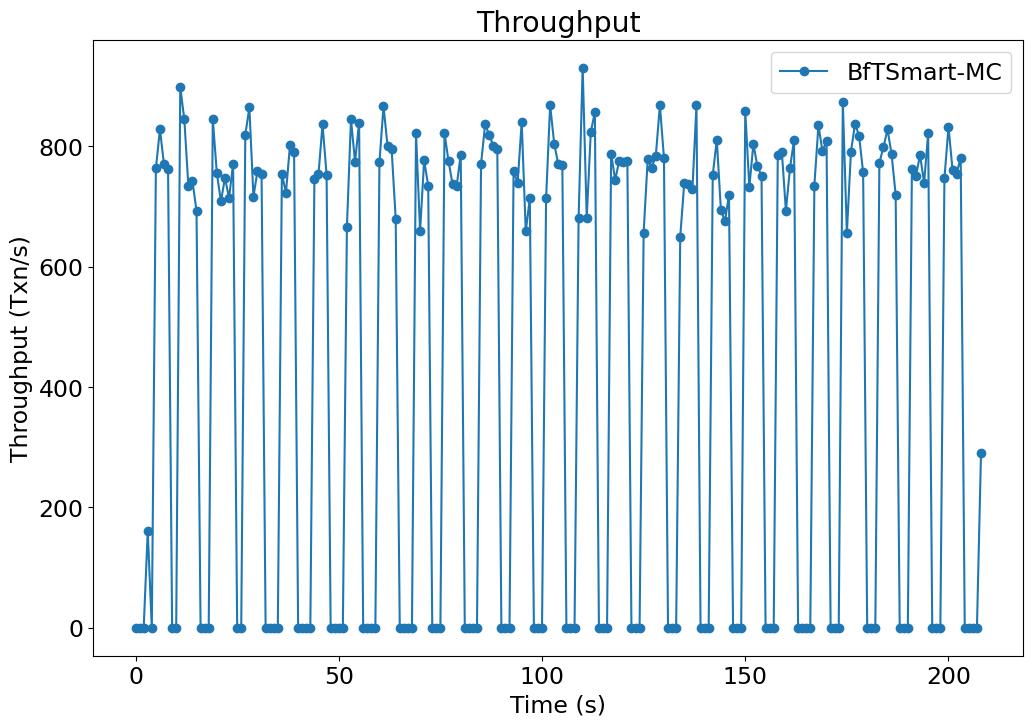

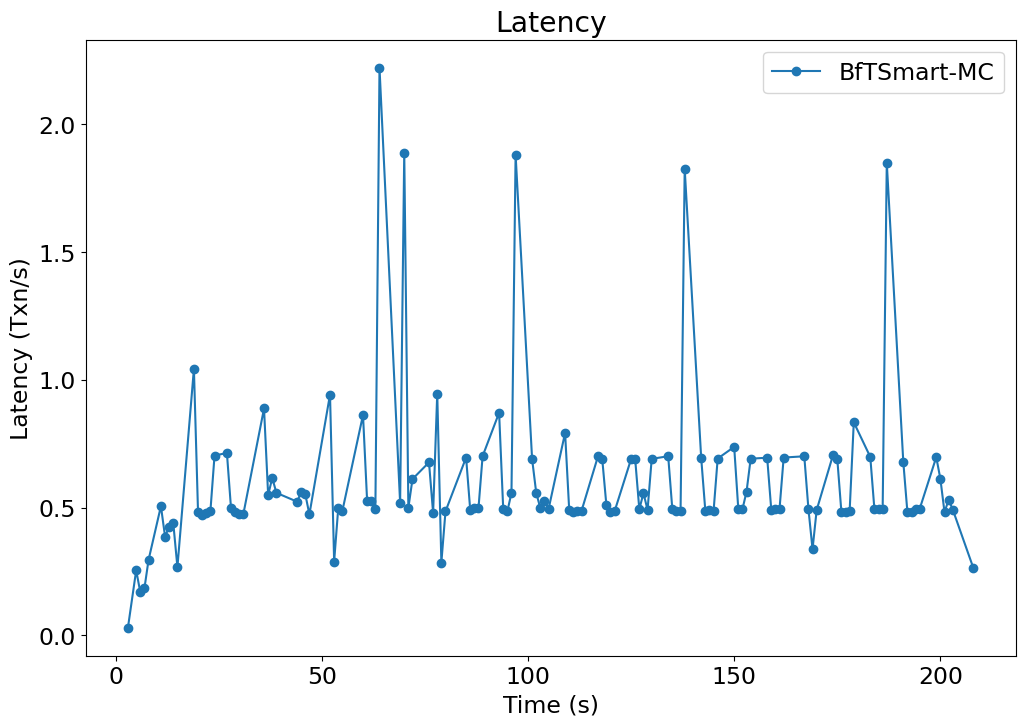

Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-00].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-05].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-06].
Deleted [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Deleted 

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 -1
37 -1
38 -1
39 -1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 -1
61 -1
0 europe-west3-c
1 europe-west3-c
0 0  'europe-west3-c'
1 1  'europe-west3-c'
2 2  'europe-west3-c'
3 3  'europe-west3-c'
4 4  'europe-west3-c'
5 5  'europe-west3-c'
6 6  'europe-west3-c'
7 7  'europe-west3-c'
8 8  'europe-west3-c'
9 9  'europe-west3-c'
10 10  'europe-west3-c'
11 11  'europe-west3-c'
12 12  'europe-west3-c'
13 13  'europe-west3-c'
14 14  'europe-west3-c'
15 15  'europe-west3-c'
16 16  'europe-west3-c'
17 17  'europe-west3-c'
18 18  'europe-west3-c'
19 19  'europe-west3-c'
20 20  'europe-west3-c'
21 21  'europe-west3-c'
22 22  'europe-west3-c'
23 23  'europe-west3-c'
24 24  'europe-west3-c'
25 25  'europe-west3-c'
26 26  'europe-west3-c'
27 27  'europe-west3-c'
28 28  '

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-01].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-01  europe-west3-c  e2-highmem-2               10.156.0.3   34.107.51.71  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-30].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-03].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-18].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.co

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-03  europe-west3-c  e2-highmem-2               10.156.0.31  34.141.70.255  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-30  europe-west3-c  e2-highmem-2               10.156.0.26  34.107.35.58  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-18  europe-west3-c  e2-highmem-2               10.156.0.7   34.159.63.17  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-32  europe-west3-c  e2-highmem-2               10.156.0.5   34.159.247.118  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-61].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-59].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-56].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-09].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-08].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-09  europe-west3-c  e2-highmem-2               10.156.0.30  34.107.113.37  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-61  asia-south1-c  e2-highmem-2               10.160.0.61  34.93.168.141  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-08  europe-west3-c  e2-highmem-2               10.156.0.14  34.159.216.86  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-56  asia-south1-c  e2-highmem-2               10.160.0.6   35.244.60.183  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-59  asia-south1-c  e2-highmem-2               10.160.0.49  35.200.217.221  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-07].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-21].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-40].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-42].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-21  europe-west3-c  e2-highmem-2               10.156.0.23  34.141.86.23  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-41].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-55].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-42  asia-south1-c  e2-highmem-2               10.160.0.62  34.93.140.209  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-28].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-07  europe-west3-c  e2-highmem-2               10.156.0.19  35.242.228.153  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-55  asia-south1-c  e2-highmem-2               10.160.0.18  34.93.179.133  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-60].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-19].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-22].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-51].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-58].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-28  europe-west3-c  e2-highmem-2               10.156.0.18  34.107.31.86  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-60  asia-south1-c  e2-highmem-2               10.160.0.34  34.93.63.127  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-40  asia-south1-c  e2-highmem-2               10.160.0.64  34.100.156.16  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-51  asia-south1-c  e2-highmem-2               10.160.0.43  34.93.193.100  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-43].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-10].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-49].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-23].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-25].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-41  asia-south1-c  e2-highmem-2               10.160.0.31  35.200.221.12  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-26].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-17].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-46].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-13].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggest

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-10  europe-west3-c  e2-highmem-2               10.156.15.198  35.198.153.198  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-19  europe-west3-c  e2-highmem-2               10.156.0.44  34.89.131.187  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-23  europe-west3-c  e2-highmem-2               10.156.0.38  34.107.56.43  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-22  europe-west3-c  e2-highmem-2               10.156.0.62  34.159.217.236  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-43  asia-south1-c  e2-highmem-2               10.160.0.22  34.93.110.99  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-34].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-48].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-37].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-25  europe-west3-c  e2-highmem-2               10.156.15.200  34.159.151.233  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-49  asia-south1-c  e2-highmem-2               10.160.0.24  34.100.200.136  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-26  europe-west3-c  e2-highmem-2               10.156.0.82  35.246.142.12  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-27].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-39].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-45].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-29].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggest

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-17  europe-west3-c  e2-highmem-2               10.156.15.203  35.198.170.57  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-34  europe-west3-c  e2-highmem-2               10.156.0.92  34.159.240.150  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-46  asia-south1-c  e2-highmem-2               10.160.0.113  34.93.31.250  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-13  europe-west3-c  e2-highmem-2               10.156.0.49  34.159.189.205  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-47].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-14].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-11].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-02].


NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-58  asia-south1-c  e2-highmem-2               10.160.0.116  34.100.218.8  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-37  europe-west3-c  e2-highmem-2               10.156.0.46  34.107.12.238  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-48  asia-south1-c  e2-highmem-2               10.160.0.114  34.100.153.55  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP   STATUS
resdb-39  europe-west3-c  e2-highmem-2               10.156.15.201  34.159.78.64  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-33].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-52].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global

NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-05  europe-west3-c  e2-highmem-2               10.156.15.197  35.246.199.179  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-45  asia-south1-c  e2-highmem-2               10.160.0.60  34.93.23.26  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-06  europe-west3-c  e2-highmem-2               10.156.0.42  34.89.128.60  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-36].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-44].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-02  europe-west3-c  e2-highmem-2               10.156.0.84  34.107.80.106  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-11  europe-west3-c  e2-highmem-2               10.156.0.115  35.234.78.225  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP  STATUS
resdb-47  asia-south1-c  e2-highmem-2               10.160.0.73  34.93.13.83  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-04].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-27  europe-west3-c  e2-highmem-2               10.156.0.41  35.234.90.249  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-33  europe-west3-c  e2-highmem-2               10.156.15.204  35.242.237.112  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-29  europe-west3-c  e2-highmem-2               10.156.0.39  35.246.133.159  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-52  asia-south1-c  e2-highmem-2               10.160.0.117  34.93.68.244  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-20].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zo

NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-57  asia-south1-c  e2-highmem-2               10.160.0.54  34.100.230.24  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-14  europe-west3-c  e2-highmem-2               10.156.0.73  34.159.42.30  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-50  asia-south1-c  e2-highmem-2               10.160.0.72  34.93.115.245  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-04  europe-west3-c  e2-highmem-2               10.156.15.205  35.198.180.141  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-44  asia-south1-c  e2-highmem-2               10.160.0.119  35.244.7.169  RUNNING
NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP   STATUS
resdb-53  asia-south1-c  e2-highmem-2               10.160.0.115  35.244.11.39  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-36  europe-west3-c  e2-highmem-2               10.156.0.61  35.198.183.177  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-31  europe-west3-c  e2-highmem-2               10.156.0.71  35.246.216.16  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP    STATUS
resdb-00  europe-west3-c  e2-highmem-2               10.156.15.202  34.107.13.191  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-15].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-16].


NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-35  europe-west3-c  e2-highmem-2               10.156.0.64  35.246.255.173  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-20  europe-west3-c  e2-highmem-2               10.156.0.72  35.246.168.32  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP    EXTERNAL_IP     STATUS
resdb-15  europe-west3-c  e2-highmem-2               10.156.15.199  34.107.120.254  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-38].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/asia-south1-c/instances/resdb-54].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP   STATUS
resdb-16  europe-west3-c  e2-highmem-2               10.156.0.86  34.89.239.62  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP     STATUS
resdb-38  europe-west3-c  e2-highmem-2               10.156.0.65  35.246.169.233  RUNNING


Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-24].
Created [https://www.googleapis.com/compute/v1/projects/ucr-ursa-major-lesani-lab/zones/europe-west3-c/instances/resdb-12].
 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.

 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
resdb-24  europe-west3-c  e2-highmem-2               10.156.0.69  35.242.240.85  RUNNING
NAME      ZONE            MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP    STATUS
resdb-12  europe-west3-c  e2-highmem-2               10.156.0.101  34.159.152.46  RUNNING


 - The resource 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831' is deprecated. A suggested replacement is 'projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20240209'.



NAME      ZONE           MACHINE_TYPE  PREEMPTIBLE  INTERNAL_IP   EXTERNAL_IP     STATUS
resdb-54  asia-south1-c  e2-highmem-2               10.160.0.118  34.100.174.237  RUNNING


In [ ]:
for cfig in config_list:    
    if 2>1:
        os.remove('node_info.csv')

        os.system('cp node_setup/'+cfig+'.csv node_info.csv')


        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count

        replica_count = 0

        for key in node_info_dict['cluster_id'].keys():
            if node_info_dict['cluster_id'][key] ==0:
                replica_count = replica_count + 1


        
        cluster_count = 0
        
        for key in node_info_dict['cluster_id']:
            print(key, node_info_dict['cluster_id'][key])
            if node_info_dict['cluster_id'][key] > cluster_count:
                cluster_count = node_info_dict['cluster_id'][key]
                
        cluster_count = cluster_count + 1
        
        n_clusters = cluster_count

        nclients = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])
            if node_info_dict['ServerOrClientregion'][i] == 1:
                nclients = nclients + 1
        nclients

        clusters_tracked = []
        cluster_regions_tracked = []

        for key in node_info_dict['region']:
            if int(node_info_dict['cluster_id'][key]) not in clusters_tracked and int(node_info_dict['cluster_id'][key]) >=0:
                clusters_tracked.append(int(node_info_dict['cluster_id'][key]))
                cluster_regions_tracked.append(node_info_dict['region'][key].strip().replace('"', '')[1:-1])


        cluster_regions_tracked     

        cluster_regions_tracked, clusters_tracked


        regions = cluster_regions_tracked



        n_regions = len(regions)

        for i,k in enumerate(regions):
            print(i,k)

        for item, idx in enumerate(node_info_dict['region'].keys()):
            print(item, idx, node_info_dict['region'][item])

        lines  = []


        for idx, key in enumerate( node_info_dict['region'].keys()):

            line = 'gcloud compute instances create resdb-'+f"{idx:02}"+' --project=ucr-ursa-major-lesani-lab --zone='+node_info_dict['region'][key].strip()[1:-1]+' --machine-type=e2-highmem-2 --network-interface=network-tier=PREMIUM,stack-type=IPV4_ONLY,subnet=default --can-ip-forward --maintenance-policy=MIGRATE --provisioning-model=STANDARD --service-account=961693926925-compute@developer.gserviceaccount.com --scopes=https://www.googleapis.com/auth/devstorage.read_only,https://www.googleapis.com/auth/logging.write,https://www.googleapis.com/auth/monitoring.write,https://www.googleapis.com/auth/servicecontrol,https://www.googleapis.com/auth/service.management.readonly,https://www.googleapis.com/auth/trace.append --tags=http-server,https-server --create-disk=auto-delete=yes,boot=yes,device-name=instance-3,image=projects/ubuntu-os-cloud/global/images/ubuntu-2004-focal-v20230831,mode=rw,size=10,type=projects/ucr-ursa-major-lesani-lab/zones/us-west1-b/diskTypes/pd-balanced --no-shielded-secure-boot --shielded-vtpm --shielded-integrity-monitoring --labels=goog-ec-src=vm_add-gcloud --reservation-affinity=any'
            lines.append(line)

        with open('launch_cloud_instances.sh', 'w') as f:
            for item in lines:
                f.write(str(item) + '\n')


        len(lines), node_info_dict['region'][key].strip()[1:-1]


        def run_command(command):
            subprocess.call(command, shell=True)

        commands = lines

        # Create a ThreadPoolExecutor or ProcessPoolExecutor, depending on your needs
        with concurrent.futures.ThreadPoolExecutor(max_workers=len(commands)) as executor:
            # Submit each command to the executor for parallel execution
            futures = [executor.submit(run_command, command) for command in commands]

            # Wait for all tasks to complete
            concurrent.futures.wait(futures)

        time.sleep(60)
        

        # os.system('sh launch_cloud_instances.sh')

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config' and 'zip' not in folder and '.' not in folder:
                shutil.rmtree(folder)


        instance_type = 'e2-small'


        redirect = '>'

        os.system('gcloud compute instances list  --format="value(networkInterfaces[0].networkIP)" '+\
                  redirect+' all_internal_ips')



        os.system('gcloud compute instances list --format="value(networkInterfaces[0].networkIP)" '+\
              redirect+' all_external_ips')

        with open('all_internal_ips') as f:
            ipList = f.read().splitlines()
        ipList = [x for x in ipList if x!='None']

        ipList, len(ipList)

        new_server_only_ips= []
        new_client_only_ips= []



        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                new_server_only_ips = new_server_only_ips + [ipList[i]]
            else:
                new_client_only_ips = new_client_only_ips + [ipList[i]]



        # new_server_only_ips= []
        # new_client_only_ips= []


        # current_region_total = 0
        # for i in range(n_regions):
        #     print(current_region_total,current_region_total+ clusters_per_region_map[i] *replica_count)
        #     new_server_only_ips = new_server_only_ips + ipList[current_region_total:current_region_total+ clusters_per_region_map[i] *replica_count]

        #     new_client_only_ips = new_client_only_ips + ipList[current_region_total+ clusters_per_region_map[i] *replica_count:
        #                                                       current_region_total+ clusters_per_region_map[i] *(replica_count+1)]


        #     current_region_total = current_region_total + clusters_per_region_map[i] *replica_count +  clusters_per_region_map[i]

        new_server_only_ips, len(new_server_only_ips)

        new_client_only_ips, len(new_client_only_ips) 

        # ipList = new_server_only_ips + new_client_only_ips

        # ipList, len(ipList)

        nclients = 0
        nservers = 0
        count = 0

        clusterIpMap = {}


        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 0:
                clusterIpMap[nservers] = ipList[count]
                nservers = nservers + 1

            count = count + 1

        nclients = 0
        nservers = 0
        count = 0

        for i in node_info_dict['ServerOrClientregion']:
        #     print(node_info_dict['ServerOrClientregion'][i])

            if node_info_dict['ServerOrClientregion'][i] == 1:
                print('test: ', 7001+nclients, ipList[count])
                clusterIpMap[7001+nclients] = ipList[count]
                nclients = nclients + 1

            count = count + 1

        clusterIpMap

        # clusterIpMap = {}

        # for i in range(len(ipList)):
        #     clusterIpMap[i] = ipList[i]


        # for i in range(nclients):

        #     clusterIpMap[7001+i] = ipList[-(nclients-i)]

        clusterPortMap1 = {}
        clusterPortMap2 = {}

        for i in range(len(ipList) - nclients):

            clusterPortMap1[i] = str(10000)

        for i in range(len(ipList) - nclients):
            clusterPortMap2[i] = str(20000)

        # clusterPortMap1[7003] = '11400'
        # clusterPortMap2[7003] = '11410'



        temp = 11900

        for i in range(nclients):

            clusterPortMap1[7001+i] = str(10000)
            clusterPortMap2[7001+i] = str(20000)

        clusterPortMap1, clusterPortMap2

        os.system('echo 3108 | sudo -S ./gradlew installDist')

        for i in range(total_count):
            os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(i)+' 1024')



        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7002)+' 1024')
        os.system('./runscripts/smartrun.sh bftsmart.tom.util.RSAKeyPairGenerator '+str(7001)+' 1024')

        os.system('echo 3108 | sudo -S ./gradlew clean')

        for key in clusterPortMap1.keys():
            if key>7002:
        #         print(key)
                print()

                for folder in os.listdir('config/'):
                    if os.path.isdir('config/'+folder) and 'keys' in folder:
                        if os.path.exists('config/'+folder+'/'+'privatekey7001'):
                            shutil.copy('config/'+folder+'/'+'privatekey7001','config/'+folder+'/'+'privatekey'+str(key))
                            shutil.copy('config/'+folder+'/'+'publickey7001','config/'+folder+'/'+'publickey'+str(key))

                print('----------')
                print()

        for i in range(n_clusters):

            if os.path.exists('config'+str(i)):
                shutil.rmtree('config'+str(i))

            os.mkdir('config'+str(i))
            os.mkdir('config'+str(i)+'/keysRSA')
            os.mkdir('config'+str(i)+'/keysSunEC')
            os.mkdir('config'+str(i)+'/keysECDSA')

        #     print('config'+str(i)+'/keysECDSA')


            shutil.copytree('config/workloads/', 'config'+str(i)+'/workloads')
            shutil.copytree('config/keysSSL_TLS/', 'config'+str(i)+'/keysSSL_TLS')
        #     print('config/workloads/', 'config'+str(i)+'/workloads')


            for file in os.listdir('config/keys/'):

                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysRSA/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysSunEC/'+file)
                shutil.copy('config/keys/'+file, 'config'+str(i)+'/keysECDSA/'+file)


            shutil.copy('config/system.config', 'config'+str(i)+'/system.config')    
            shutil.copy('config/logback.xml', 'config'+str(i)+'/logback.xml')





        clusterIpMap, clusterPortMap1

        def find_key_by_value(dictionary, value):
            for key, val in dictionary.items():
                if val == value:
                    return key
            # If the value is not found, you might want to handle this case accordingly.
            return None


        node_info_dict

        find_key_by_value(node_info_dict['ServerID'], 4)

        for n_cluster in range(n_clusters):

            with open('config'+str(n_cluster)+'/hosts.config','w') as file:

                for key in clusterIpMap:
                    if key < 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                        print('test: ',str(key)+' '+clusterIpMap[key]+' '  +clusterPortMap1[key]+' ' +  clusterPortMap2[key]+' '+str(node_info_dict['cluster_id'][find_key_by_value(node_info_dict['ServerID'], key)] )+'\n')
                for key in clusterIpMap:
                    if key >= 7000:
                        file.writelines(str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')
                        print('test: ', str(key)+' '+clusterIpMap[key]+' '+clusterPortMap1[key]+'\n')

                file.close()


        # for n_cluster in range(n_clusters):

        #     with open('config'+str(n_cluster)+'/hosts.config','w') as file:

        #         for n_cluster1 in range(n_clusters):

        #             for i_replica in range(replica_count):
        #     #             file.writelines(str(i_replica)+' '+clusterIpMap[n_cluster*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster*replica_count+i_replica]+'\n')
        #                 file.writelines(str(n_cluster1*replica_count+i_replica)+' '+clusterIpMap[n_cluster1*replica_count+i_replica]+' '  +clusterPortMap1[n_cluster1*replica_count+i_replica]+' ' +  clusterPortMap2[n_cluster1*replica_count+i_replica]+' '+str(n_cluster1)+'\n')

        #         for iter_ in range(len(ipList) - (n_clusters*replica_count)-nclients):
        #             print((n_clusters*replica_count) + iter_)

        # #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(iter_%n_clusters)+'\n')
        #             file.writelines(str((n_clusters*replica_count) + iter_)+' '+clusterIpMap[(n_clusters*replica_count) + iter_]+' '  +clusterPortMap1[(n_clusters*replica_count) + iter_]+' ' +  clusterPortMap2[(n_clusters*replica_count) + iter_]+' '+str(0%n_clusters)+'\n')

        #         for i in range(nclients):
        #             file.writelines(str(7001+i)+' '+clusterIpMap[7001+i]+' '+clusterPortMap1[7001+i]+'\n')


        #         file.close()


        replica_count

        # for n_cluster in range(n_clusters):
        #     with open('config'+str(n_cluster)+'/system.config','r') as file:
        #         data = file.readlines()
        #         f = int(np.ceil((replica_count-1)/3))
        #         print('f is',f )

        #         for n_line in range(len(data)):
        #             if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


        #                 data[n_line] = 'system.servers.num = '+str(replica_count)
        #                 print(data[n_line])

        #             if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.servers.f = '+str(f)
        #                 print(data[n_line])


        #             if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
        #                 data[n_line] = 'system.initial.view = '
        #                 for iter_view in range(replica_count):
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        # #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
        #                     print(data[n_line])

        #                 data[n_line] = data[n_line][:-1]
        #                 print(data[n_line])



        #         file.close()

        #     with open('config'+str(n_cluster)+'/system.config', 'w') as f:
        #         for line in data:
        #             f.write(f"{line}\n")




        for n_cluster in range(n_clusters):
            with open('config'+str(n_cluster)+'/system.config','r') as file:
                data = file.readlines()


                nservers = 0
                server_id_list = []



                for i in node_info_dict['ServerOrClientregion']:
                    if node_info_dict['ServerOrClientregion'][i] == 0 and \
                    node_info_dict['cluster_id'][i]  == n_cluster:
                        nservers = nservers + 1
                        server_id_list.append(node_info_dict['ServerID'][i])

                f = int(np.ceil((nservers-1)/3))
                print('f is',f )


                for n_line in range(len(data)):
                    if ('system.servers.num' in data[n_line]) and '#' not in data[n_line]:


                        data[n_line] = 'system.servers.num = '+str(nservers)
                        print(data[n_line])

                    if ('system.servers.f' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.servers.f = '+str(f)
                        print(data[n_line])


                    if ('system.initial.view' in data[n_line]) and '#' not in data[n_line]:
                        data[n_line] = 'system.initial.view = '
                        for iter_view in server_id_list:
                            data[n_line] = data[n_line] +str(iter_view)+','
        #                     data[n_line] = data[n_line] +str(n_cluster*replica_count+iter_view)+','
                            print(data[n_line])

                        data[n_line] = data[n_line][:-1]
                        print(data[n_line])



                file.close()

            with open('config'+str(n_cluster)+'/system.config', 'w') as f:
                for line in data:
                    f.write(f"{line}\n")


        for n_cluster in range(n_clusters):
            for i in range(999):

                for ncls in  range(1):


        #             print('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                         'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))



                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'publickey'+str(1000+(ncls*100)+i))
                    shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
                                'config'+str(n_cluster)+'/keysRSA/'+'privatekey'+str(1000+(ncls*100)+i))

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'publickey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'publickey7002')

        #         shutil.copy('config'+str(n_cluster)+'/keysRSA/'+'privatekey7002', \
        #                     'config'+str(n_cluster)+'/keysRSA/'+'privatekey7002')

        # os.system('git remote set-url origin https://github.com/tmane002/BftSmart_Final.git')

        os.system('git add .; git commit -m "Working Post Submission: testing";git push --force origin HEAD:main')
        

        
        

        
        
        
        
        time.sleep(30)

        # regions = [ 'us-west1-b', 'us-west1-b', 'us-west1-b']
        # regions = [ 'us-west1-b']


        instance_type = 'e2-small'

        df =pd.read_csv('node_info.csv')

        node_info_dict = df.to_dict()

        node_info_dict

        f = open('all_external_ips', "r")
        data1 = [line.strip() for line in f.readlines()]

        data1 = [x for x in data1 if x!='None']

        f = open('all_internal_ips', "r")
        data2 = [line.strip() for line in f.readlines()]

        data2 = [x for x in data2 if x!='None']

        data2, len(data2)

        data = []

        skip_instances = 0

        for i in range(skip_instances, len(data1)):
            if data1[i]!='None':
                data.append(data1[i] + '    ' + data2[i])

        data, len(data)

        for index, item in enumerate(data1):
            if 'publicIP' not in node_info_dict.keys():
                node_info_dict['publicIP'] = {}


            node_info_dict['publicIP'][index] = item 


        for index, item in enumerate(data2):
            if 'privateIP' not in node_info_dict.keys():
                node_info_dict['privateIP'] = {}

            node_info_dict['privateIP'][index] = item 



        for index, item in enumerate(data):
            if 'publicAndprivateIP' not in node_info_dict.keys():
                node_info_dict['publicAndprivateIP'] = {}

            node_info_dict['publicAndprivateIP'][index] = item 

        node_info_dict









        # time.sleep(60)

        total_count = 0

        for key in node_info_dict['ServerOrClientregion'].keys():
            if node_info_dict['ServerOrClientregion'][key] ==0:
                total_count = total_count + 1

        total_count





        def getTimeThps(file, flag):

            f = open(file, "r")
            data = f.readlines() 

            times = []
            thputs = []
            for line in data:
                if 'throughput[ops/s]' in line:
                    lineData = (line[13+line.find('max[ops/s])>'):-2])
                    print(lineData)

                    times.append(lineData.split('|')[0])
                    thputs.append(lineData.split('|')[-2])
            if (flag): 
                times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
                thputs.append(0)

            return np.array(times).astype(float), np.array(thputs).astype(float) 

        with open('all_external_ips') as f:
            lines = f.read().splitlines()


        lines = [x for x in lines if x!='None']
        lines, len(lines)

        for ip in lines:
            if ip!='None':
                current = (ip.split('.'))

                print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

        ## Set number of clusters

        nclusters = 0

        for folder in os.listdir('.'):
            if 'config' in folder and folder!='config':
                nclusters = nclusters + 1


        print(nclusters)





        nreplicas = int(total_count/nclusters)
        
        nclients = 0
        
        for key in node_info_dict['ServerOrClientregion']:
            if node_info_dict['ServerOrClientregion'][key]==1:
                nclients = nclients + 1
        


        nodeIps = []
        clientIps = []

        for i in range(total_count + nclients):
            if node_info_dict['ServerOrClientregion'][i] ==0:
                nodeIps.append(lines[i])
            else:
                clientIps.append(lines[i])


        # nodeIps = lines[:nclusters* nreplicas]


        # no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
        no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]


        experiment = 'bft_mc_'+cfig 

        # clientIps = lines[-(nclusters):]



        # clientIps = lines[-nclients:]



        clientIps, no_cluster_yet_nodes



        node_info_dict

        node_info_dict['region'][0].strip()

        ## Functions

        def setup(i):

            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' commands.sh'+' resdb-'+f"{i:02}"+':/home/tejas/commands.sh'

                print(command)
                os.system(command)

        def initialize(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo sh commands.sh"'


                os.system(command)


        def git_clone(i):
            ip = lines[i]
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'


                os.system(command)

        def git_pull(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "git config --global --add safe.directory /home/tejas/BftSmart_Final; cd BftSmart_Final; sudo git pull"'


                os.system(command)

        def compile_job(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo ./gradlew installDist"'


                os.system(command)



        def clean_job(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm config/currentView; '
            for iter_ in range(nclusters):
                rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '


            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'


                os.system(command)


        def clean_all(i):
            ip = node_info_dict['publicIP'][i] 

            rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'



            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "sudo rm nohup.out; '+rm_command+'"'


                os.system(command)





        #     if ip!='None' and( ip in no_cluster_yet_nodes):

        #         current = (ip.split('.'))
        #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
        #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


        #         os.system(command)        
        # #         print(command)

        def check_node(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "tail -n 1000 nohup.out"'


                os.system(command)
        #         print(command)


        def run_basic_client(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                current = (ip.split('.'))


                cmd_arg = str(node_info_dict['clientID'][i])



                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'


                os.system(command)


        def kill_java(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None':
                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo killall java; sudo killall nohup; sudo killall hotstuff-app; sudo killall hotstuff-client;"'


                os.system(command)



        def kill_clients(i):
            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and ip in clientIps:
                current = (ip.split('.'))
                command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'


                os.system(command)

        def run_server_node_check(i):
            ip = node_info_dict['publicIP'][i] 

            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'


                print(command)



        # for i in range(len(lines)):
        #     run_server_node_check(i)

        def run_basic_client_check(i):
            cmd_arg = ''

            ip = node_info_dict['publicIP'][i] 
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:

                cmd_arg = str(node_info_dict['clientID'][i])


        #         print(i, cmd_arg)

                current = (ip.split('.'))
                command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'


                print(command)



        ## First Time Setup

        lines, len(lines)

        # for i in range(10):
        #     setup(i)


        results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
        print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
        print(results)  

        # ## GIT Clone/Pull



        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


        # print(results)  

        # ## Compile Job

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        print(results)  

        # ## CLEAN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        # print(results)  

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        def run_server_node(i):
            ip = node_info_dict['publicIP'][i] 
        #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:

                current = (ip.split('.'))
                command = 'gcloud compute ssh --zone "'+str(node_info_dict['region'][i].strip()[1:-1])+'" "resdb-'+f"{i:02}"+'" --project "ucr-ursa-major-lesani-lab" --command "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(node_info_dict['ServerID'][i])+' >../nohup.out 2>&1 &"'


                os.system(command)



        # for i in node_info_dict['publicIP']:
        #     run_server_node(i)

        ## RUN SERVERS

        # results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  

        ### CHECK NODE RESULT

        # check_node(0)

        # ## Run basic client

        # # time.sleep(20)
        # results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
        # print(results)  

        # check_node(0)

        # time.sleep(60)

        # results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        # results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

        ## Main Job

        # os.system('git add .; git commit -m "test";git push')


        # time.sleep(60)

        os.system('git add .; git commit -m "Working with modified ClusterInfo";git push --force origin HEAD:main')

# if 2>1:
#     if 2>1:
        
        #     %%time


        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

        results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
        # print(results) 





        results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
        # results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


        results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
        # print(results)  


        print('XXXXXXXX Started Servers XXXXXXXXXXXX')

        time.sleep(60)
        

        check_node(7)

        print('XXXXXXXX Started Clients XXXXXXXXXXXX')

        results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))



        time.sleep(80)
#         results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in [0])
        time.sleep(120)

        results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

        check_node(0)

        if not os.path.exists('../Experiments/'+experiment):
            os.mkdir('../Experiments/'+experiment)

        os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

                break;



        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 



            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
                print(command)
                os.system(command)


        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            print(i)
            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
                print('client copying id= ',i)


        node_info_dict

        clientIps




        def getTimesThputs(file):
            f = open(file, "r")
            data = f.readlines() 
            times = []
            thputs = []
            latencies = []
            for line in data:
        #         print(line)
                if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

        #         print(line)
                    times.append(line.split('sec:')[0].strip())
                    thputs.append(line.split(';')[1].split('current')[0].strip())
                
                
                    read_lat = '0'
                    write_lat = '0'
                    
                    if ('READ AverageLatency' in line):
                        
                        print(line)

                        read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()
                        
                        
                    if ('UPDATE AverageLatency' in line):                    
                        
                        write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


                    if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
                        latencies.append(line.split('=')[1].split(']')[0].strip())
                    else:
                        read_frac = 0
                        write_frac = 0
                        
                        if float(read_lat) > 0:
                            read_frac = 0.85
                            
                        if float(write_lat) > 0:
                            write_frac = 0.15
                            
#                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))
                        
                        lat = str( (write_frac * float(write_lat) +\
                                    read_frac*float(read_lat))/(write_frac+read_frac)\
                                 )
                        latencies.append(lat)

                    print(line,latencies[-1],thputs[-1],times[-1])

            return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


        times_thputsDict = {}
        times_latsDict = {}


        for ip in clientIps[:1]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

            print(times, thputs)
            for i in range(len(times)):
                times_thputsDict[times[i]] = thputs[i]
                times_latsDict[times[i]] = lats[i]


        for ip in clientIps[1:]:    
            i = clientIps.index(ip)

            times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


            for i in range(len(times)):

                if times[i] in times_thputsDict.keys():
                    times_thputsDict[times[i]] += thputs[i]

                if times[i] in times_latsDict.keys():
                    times_latsDict[times[i]] += lats[i]


        times_thputsDict



        PIK = '../Experiments/'+experiment+"/pickle.dat"

        data = [times_thputsDict, times_latsDict]

        with open(PIK, "wb") as f:
            pickle.dump(data, f)

        experiment

        # experiment = 'TestRun2_8_clusters_2'
        # PIK = '../Experiments/'+experiment+"/pickle.dat"

        data2 = []
        
        with open(PIK, "rb") as f:
            data2 =  pickle.load(f)


        dict1 = data2[0]
        dict2 = data2[1]



        times1 = np.array(list(dict1.keys()))
        thputs = np.array(list(dict1.values()))

        times2 = np.array(list(dict2.keys()))
        lats = np.array(list(dict2.values()))

        

        

        times_new = [x for x in range(1+int(times1[-1]))]
        thputs_new = [0 for x in range(1+int(times1[-1]))]

        for idx, t in enumerate(times1):
            thputs_new[int(t)] = thputs[idx]

    

        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times_new[:], thputs_new[:], '-o', label='BfTSmart-MC')


        pl.title(r'Throughput')


        pl.xlabel('Time (s)')
        pl.ylabel('Throughput (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
        pl.show()




        pl.figure(figsize = (12,8))
        pl.rcParams.update({'font.size': 17})
        pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


        pl.title(r'Latency')


        pl.xlabel('Time (s)')
        pl.ylabel('Latency (Txn/s)')
        pl.legend()
        pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
        pl.show()

        times1, lats

        lats, np.average(lats[-85:-5])/len(clientIps)

        np.sum(thputs),  np.average(thputs[-85:-5])

        thputs

        np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

        # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

        np.sum((thputs[:180]))

        np.sum((thputs[:180]))
        
        
        for i in node_info_dict['publicIP']:
            ip = node_info_dict['publicIP'][i] 


            if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
                current = (ip.split('.'))
                command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

                os.system(command)

                break;




        os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
        os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')

#     except:
        
#         os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')
        
#         continue
    

In [ ]:
node_info_dict['cluster_id']

In [ ]:


#         for i in node_info_dict['publicIP']:
#             ip = node_info_dict['publicIP'][i] 


#             if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
#                 current = (ip.split('.'))
#                 command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

#                 os.system(command)

#                 break;



#         for i in node_info_dict['publicIP']:
#             ip = node_info_dict['publicIP'][i] 



#             if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
#                 print('client copying id= ',i)
#                 current = (ip.split('.'))
#                 command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
#                 print(command)
#                 os.system(command)


#         for i in node_info_dict['publicIP']:
#             ip = node_info_dict['publicIP'][i] 


#             print(i)
#             if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
#                 print('client copying id= ',i)


#         node_info_dict

#         clientIps




#         def getTimesThputs(file):
#             f = open(file, "r")
#             data = f.readlines() 
#             times = []
#             thputs = []
#             latencies = []
#             for line in data:
#         #         print(line)
#                 if not line.startswith('--') and 'current ops/sec; ' in line and 'AverageLatency(us)=' in line and not 'JVM' in line:

#         #         print(line)
#                     times.append(line.split('sec:')[0].strip())
#                     thputs.append(line.split(';')[1].split('current')[0].strip())
                
                
#                     read_lat = '0'
#                     write_lat = '0'
                    
#                     if ('READ AverageLatency' in line):
                        
#                         print(line)

#                         read_lat = line.split('READ AverageLatency(us)=')[1].split(']')[0].strip()
                        
                        
#                     if ('UPDATE AverageLatency' in line):                    
                        
#                         write_lat = line.split('UPDATE AverageLatency(us)=')[1].split(']')[0].strip()


#                     if (('READ AverageLatency' not in line) and ('UPDATE AverageLatency' not in line)):
#                         latencies.append(line.split('=')[1].split(']')[0].strip())
#                     else:
#                         read_frac = 0
#                         write_frac = 0
                        
#                         if float(read_lat) > 0:
#                             read_frac = 0.85
                            
#                         if float(write_lat) > 0:
#                             write_frac = 0.15
                            
# #                         print(line, write_frac, read_frac, float(read_lat), float(write_lat))
                        
#                         lat = str( (write_frac * float(write_lat) +\
#                                     read_frac*float(read_lat))/(write_frac+read_frac)\
#                                  )
#                         latencies.append(lat)

#                     print(line,latencies[-1],thputs[-1],times[-1])

#             return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  


#         times_thputsDict = {}
#         times_latsDict = {}


#         for ip in clientIps[:1]:    
#             i = clientIps.index(ip)

#             times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')

#             print(times, thputs)
#             for i in range(len(times)):
#                 times_thputsDict[times[i]] = thputs[i]
#                 times_latsDict[times[i]] = lats[i]


#         for ip in clientIps[1:]:    
#             i = clientIps.index(ip)

#             times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')


#             for i in range(len(times)):

#                 if times[i] in times_thputsDict.keys():
#                     times_thputsDict[times[i]] += thputs[i]

#                 if times[i] in times_latsDict.keys():
#                     times_latsDict[times[i]] += lats[i]


#         times_thputsDict



#         PIK = '../Experiments/'+experiment+"/pickle.dat"

#         data = [times_thputsDict, times_latsDict]

#         with open(PIK, "wb") as f:
#             pickle.dump(data, f)

#         experiment

#         # experiment = 'TestRun2_8_clusters_2'
#         # PIK = '../Experiments/'+experiment+"/pickle.dat"

#         data2 = []
        
#         with open(PIK, "rb") as f:
#             data2 =  pickle.load(f)


#         dict1 = data2[0]
#         dict2 = data2[1]



#         times1 = np.array(list(dict1.keys()))
#         thputs = np.array(list(dict1.values()))

#         times2 = np.array(list(dict2.keys()))
#         lats = np.array(list(dict2.values()))

        

        

#         times_new = [x for x in range(1+int(times1[-1]))]
#         thputs_new = [0 for x in range(1+int(times1[-1]))]

#         for idx, t in enumerate(times1):
#             thputs_new[int(t)] = thputs[idx]

    

#         pl.figure(figsize = (12,8))
#         pl.rcParams.update({'font.size': 17})
#         pl.plot(times_new[:], thputs_new[:], '-o', label='BfTSmart-MC')


#         pl.title(r'Throughput')


#         pl.xlabel('Time (s)')
#         pl.ylabel('Throughput (Txn/s)')
#         pl.legend()
#         pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
#         pl.show()




#         pl.figure(figsize = (12,8))
#         pl.rcParams.update({'font.size': 17})
#         pl.plot(times1[:], lats[:]/ len(clientIps), '-o', label='BfTSmart-MC')


#         pl.title(r'Latency')


#         pl.xlabel('Time (s)')
#         pl.ylabel('Latency (Txn/s)')
#         pl.legend()
#         pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
#         pl.show()

#         times1, lats

#         lats, np.average(lats[-85:-5])/len(clientIps)

#         np.sum(thputs),  np.average(thputs[-85:-5])

#         thputs

#         np.average(thputs[60:80]), np.average(lats[60:80])/nclusters, np.average(thputs[-35:-5]), np.average(lats[-35:-5])

#         # np.average(lats[-50:]), np.average(thputs[-50:]) # (0.0542783668, 166.87759999999997)

#         np.sum((thputs[:180]))

#         np.sum((thputs[:180]))
        
        
#         for i in node_info_dict['publicIP']:
#             ip = node_info_dict['publicIP'][i] 


#             if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
#                 current = (ip.split('.'))
#                 command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(node_info_dict['ServerID'][i])+'.out'

#                 os.system(command)

#                 break;




#         os.system('gcloud compute instances delete --zone=europe-west3-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=asia-south1-c --quiet $(gcloud compute instances list --format="value(name)")')
#         os.system('gcloud compute instances delete --zone=us-west1-b --quiet $(gcloud compute instances list --format="value(name)")')


In [ ]:



# for i in node_info_dict['publicIP']:
#     ip = node_info_dict['publicIP'][i] 



#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
#         print('client copying id= ',i)
#         current = (ip.split('.'))
#         command = 'gcloud compute scp --zone "'+str(node_info_dict['region'][i].strip()[1:-1]) +'"'+' resdb-'+f"{i:02}"+':/home/tejas/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
#         print(command)
#         os.system(command)


In [ ]:
np.average(lats)/nclusters

In [ ]:
np.average(thputs[60:80])

In [ ]:
n_clusters